In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [3]:
train = pd.read_csv('train_timeframes_indicators2.csv')
test = pd.read_csv('test_timeframes_indicators2.csv')

In [4]:
margin_size = 50
time_limit = 30//5
frames = ['_5min']
window_size = 6*60//5

In [5]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [6]:
train = train[[d.minute % 5 == 0 for d in train['datetime']]]
test = test[[d.minute % 5 == 0 for d in test['datetime']]]

In [7]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [8]:
y_multiple = 1
y_true = 100*(train['close_1min'].values[time_limit:] - train['close_1min'].values[:-time_limit])/train['close_1min'].values[:-time_limit]
y_true_test = 100*(test['close_1min'].values[time_limit:] - test['close_1min'].values[:-time_limit])/test['close_1min'].values[:-time_limit]
y_true = np.sign(y_true)*np.log(abs(y_true)+1)*y_multiple
y_true_test = np.sign(y_true_test)*np.log(abs(y_true_test)+1)*y_multiple

y_true = y_true.reshape((y_true.shape[0], 1))
y_true_test = y_true_test.reshape((y_true_test.shape[0], 1))

In [3]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.112708
1,0.090008
2,0.089628
3,0.160459
4,0.188066


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [9]:
test_size = y_true_test.shape[0]
simulation_size = 10

minmax = MinMaxScaler().fit(y_true)
df_train = minmax.transform(y_true)
df_test = minmax.transform(y_true_test)
df_train.shape, df_test.shape

((379812, 1), (23390, 1))

In [5]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [65]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = 0.8)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real)
    predict = np.array(predict)
    percentage = np.mean(abs(real - predict)/real)
    return percentage

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [11]:
num_layers = 1
size_layer = 64
timestamp = 32
epoch = 1000
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.001

In [64]:
def get_return(ps, trues, t, threshold=1.1, r=1.0, margin_size=1.0):
    diff = ps * t['close_1min'].values/100
    profits = trues[abs(diff) > threshold * t['spread'].values]
    for i in range(len(profits)):
        sign = np.sign(diff[i])
        close = t['close_1min'].iloc[i]
        spread = t['spread'].iloc[i]
        r = r * (1 + margin_size*sign*(profits[i] - sign*100*spread/close))
    return r

In [ ]:
tf.reset_default_graph()
modelnn = Attention(size_layer, size_layer, learning_rate, df_train.shape[1], df_train.shape[1])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [66]:
#     pbar = tqdm(range(epoch), desc = 'train loop')
thresholds = [1.1, 2, 5, 10, 20, 30, 40]
for i in range(epoch):
    total_loss, total_acc = [], []
    total_return = {t: 1.0 for t in thresholds}
    pbar2 = tqdm(range(0, df_train.shape[0] - 1, timestamp), desc = 'batch loop')
    for k in pbar2:
        index = min(k + timestamp, df_train.shape[0] - 1)
        batch_x = np.expand_dims(
            df_train[k : index, :], axis = 0
        )
        batch_y = df_train[k + 1 : index + 1, :]
        logits, _, loss = sess.run(
            [modelnn.logits, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y
            },
        ) 
        total_loss.append(loss)
        trues = 100*(train['close_1min'].values[k+1+time_limit : index+1+time_limit] - train['close_1min'].values[k+1 : index+1])/train['close_1min'].values[k+1 : index+1]
        output_predict = minmax.inverse_transform(logits)
        output_predict = (np.sign(output_predict)*(np.exp(np.sign(output_predict)*output_predict/y_multiple)-1))
        output_predict = output_predict.flatten()
        total_acc.append(calculate_accuracy(output_predict, trues))
        for t in thresholds:
            total_return[t] = max(get_return(output_predict, trues, train.iloc[k+1 : index+1], threshold=t, r=total_return[t]), 0.0)
        pbar2.set_postfix(cost = '{0:2.3g}'.format(loss), mse = '{0:2.3g}'.format(total_acc[-1]))
    print(f"EPOCH: {i}, Loss: {np.mean(total_loss)}, MSE: {np.mean(total_acc)}")
    for t in thresholds:
        print(f"Return{t}: {total_return[t]}", end=', ')
#         pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=8.39e-06, mse=-0.0548]

EPOCH: 0, Loss: 1.8068685676553287e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:56, 67.31it/s, cost=7.18e-05, mse=-0.149]

EPOCH: 1, Loss: 1.685411734797526e-05, MSE: 0.08452669920507185
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:00, 65.69it/s, cost=1.99e-05, mse=0.436]

EPOCH: 2, Loss: 1.7023894542944618e-05, MSE: -0.10143270042142949
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=2.83e-05, mse=0.0175]

EPOCH: 3, Loss: 1.665005402173847e-05, MSE: 0.07232878365096329
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 1.768550257308536e-33, Return40: 7.619785248614705e-26, 

batch loop:   0%|                                         | 7/11870 [00:00<02:58, 66.38it/s, cost=2.21e-05, mse=0.0521]

EPOCH: 4, Loss: 1.6404697817051783e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:57, 66.67it/s, cost=3.43e-05, mse=0.188]

EPOCH: 5, Loss: 1.6566253179917112e-05, MSE: -0.40279692710232895
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.40it/s, cost=5.77e-05, mse=-0.0325]

EPOCH: 6, Loss: 1.6150963347172365e-05, MSE: 0.015224543435208064
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 1.320763173901962e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=6.56e-05, mse=-0.0522]

EPOCH: 7, Loss: 1.72212839970598e-05, MSE: 0.11470103163178318
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:00, 65.79it/s, cost=1.32e-05, mse=-0.536]

EPOCH: 8, Loss: 1.5915435142233036e-05, MSE: -0.007903006641714543
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 1.8550370289519198e-35, Return40: 3.439491733940465e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=7.01e-05, mse=-0.0911]

EPOCH: 9, Loss: 1.5894975149421953e-05, MSE: nan
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                            | 7/11870 [00:00<03:04, 64.22it/s, cost=4e-05, mse=0.0268]

EPOCH: 10, Loss: 1.6072541257017292e-05, MSE: -inf
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 1.1556642945291285e-35, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.38it/s, cost=4.71e-05, mse=-0.0132]

EPOCH: 11, Loss: 1.5932557289488614e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:56, 67.31it/s, cost=5.65e-05, mse=-0.0439]

EPOCH: 12, Loss: 1.554341179144103e-05, MSE: 0.057816419623999964
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.16e-05, mse=-0.203]

EPOCH: 13, Loss: 1.586945836606901e-05, MSE: inf
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: 0.0, Return20: 6.111281509994322e-25, Return30: 8.834734668968871e-35, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.22it/s, cost=2.19e-05, mse=0.0301]

EPOCH: 14, Loss: 1.556791175971739e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 9.178600966839324e-30, 

batch loop:   0%|                                         | 7/11870 [00:00<03:07, 63.38it/s, cost=3.38e-05, mse=0.0769]

EPOCH: 15, Loss: 1.6144402252393775e-05, MSE: -0.06361713929613307
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 2.6160609200236362e-36, Return40: 5.288506406534255e-32, 

batch loop:   0%|                                           | 7/11870 [00:00<02:59, 66.04it/s, cost=2.4e-05, mse=0.576]

EPOCH: 16, Loss: 1.585938298376277e-05, MSE: -0.013066611358402192
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 1.3213243085501094e-32, Return40: 2.8814264501851512e-27, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.12e-05, mse=-0.0885]

EPOCH: 17, Loss: 1.5583838830934837e-05, MSE: inf
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:06, 63.64it/s, cost=2.53e-05, mse=5.16]

EPOCH: 18, Loss: 1.589293242432177e-05, MSE: -0.02267388470904988
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:05, 63.86it/s, cost=2.19e-05, mse=-0.272]

EPOCH: 19, Loss: 1.5650803106836975e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:57, 66.67it/s, cost=2.39e-05, mse=0.165]

EPOCH: 20, Loss: 1.571766370034311e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:03, 64.81it/s, cost=1.95e-05, mse=0.45]

EPOCH: 21, Loss: 1.5286286725313403e-05, MSE: -inf
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.81it/s, cost=7.9e-06, mse=-0.0496]

EPOCH: 22, Loss: 1.5482921298826113e-05, MSE: -0.07927541432269648
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=1.34e-05, mse=-0.94]

EPOCH: 23, Loss: 1.5854722732910886e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.35it/s, cost=2.05e-05, mse=0.0453]

EPOCH: 24, Loss: 1.5617817552993074e-05, MSE: -0.18595026754446828
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.51it/s, cost=1.27e-05, mse=0.236]

EPOCH: 25, Loss: 1.4838500646874309e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.81it/s, cost=2.19e-05, mse=0.0694]

EPOCH: 26, Loss: 1.5215521671052556e-05, MSE: -0.08080360236988159
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.47e-05, mse=-0.503]

EPOCH: 27, Loss: 1.5153151252889074e-05, MSE: 0.14098646418417132
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:00, 65.72it/s, cost=1.49e-05, mse=-0.131]

EPOCH: 28, Loss: 1.5025375432742294e-05, MSE: 0.09969382391239678
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 8.548473101675625e-29, Return30: 8.314911812671581e-29, Return40: 2.320199147068882e-26, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.22it/s, cost=2.33e-05, mse=0.0361]

EPOCH: 29, Loss: 1.5108886145753786e-05, MSE: 0.05440210729777295
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:02, 65.01it/s, cost=1.68e-05, mse=6.67]

EPOCH: 30, Loss: 1.4817735063843429e-05, MSE: 0.033390590916025635
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:08, 62.99it/s, cost=1.16e-05, mse=0.228]

EPOCH: 31, Loss: 1.509704816271551e-05, MSE: -0.02478049710222214
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.23e-05, mse=-0.0429]

EPOCH: 32, Loss: 1.4938595086277928e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=2.4e-05, mse=0.0934]

EPOCH: 33, Loss: 1.4555229427060112e-05, MSE: 0.054929473000585656
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.21e-05, mse=-0.0391]

EPOCH: 34, Loss: 1.479381990066031e-05, MSE: 0.058070799547344884
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 64.83it/s, cost=1.01e-05, mse=-0.0548]

EPOCH: 35, Loss: 1.5009299204393756e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=1.07e-05, mse=-0.178]

EPOCH: 36, Loss: 1.4800539247517008e-05, MSE: -0.024687591975770418
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.35e-05, mse=-0.152]

EPOCH: 37, Loss: 1.52790526044555e-05, MSE: -0.029712521685072813
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.03e-05, mse=-0.027]

EPOCH: 38, Loss: 1.470130246161716e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.35e-05, mse=-0.0558]

EPOCH: 39, Loss: 1.463512671762146e-05, MSE: -0.02309426196031625
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.38e-05, mse=-0.0509]

EPOCH: 40, Loss: 1.4698380255140364e-05, MSE: -0.11232546426576022
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=8.55e-06, mse=-0.0405]

EPOCH: 41, Loss: 1.4578781701857224e-05, MSE: 0.0017500879855527978
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.45e-05, mse=-0.0532]

EPOCH: 42, Loss: 1.473825250286609e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.96e-05, mse=-0.208]

EPOCH: 43, Loss: 1.450466243113624e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 2.5059387365263495e-33, Return30: 2.0474587752671134e-37, Return40: 3.8386730221840886e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.65e-05, mse=-0.0438]

EPOCH: 44, Loss: 1.4311772247310728e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.57e-05, mse=-0.0863]

EPOCH: 45, Loss: 1.4519987416861113e-05, MSE: 0.0034221409714153043
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                            | 7/11870 [00:00<02:59, 66.04it/s, cost=1e-05, mse=0.0898]

EPOCH: 46, Loss: 1.45697404150269e-05, MSE: 0.07273861118909031
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.22e-05, mse=-0.0804]

EPOCH: 47, Loss: 1.4861745512462221e-05, MSE: 0.025491167609196907
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=3.6e-05, mse=-0.276]

EPOCH: 48, Loss: 1.4665783965028822e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=1.68e-05, mse=-0.0403]

EPOCH: 49, Loss: 1.4379817912413273e-05, MSE: 0.13091547943933862
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=2.24e-05, mse=-0.29]

EPOCH: 50, Loss: 1.4775298041058704e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.81it/s, cost=2.25e-05, mse=0.0924]

EPOCH: 51, Loss: 1.4889237718307413e-05, MSE: 0.16477551577322602
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<02:59, 66.04it/s, cost=1.47e-05, mse=6.99]

EPOCH: 52, Loss: 1.4122523680271115e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: inf, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:05, 64.12it/s, cost=1.57e-05, mse=-0.064]

EPOCH: 53, Loss: 1.4028415534994565e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.21e-05, mse=-0.0766]

EPOCH: 54, Loss: 1.4991742318670731e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.24it/s, cost=1.15e-05, mse=-0.0279]

EPOCH: 55, Loss: 1.4270609426603187e-05, MSE: inf
Return1.1: inf, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=2.07e-05, mse=-0.054]

EPOCH: 56, Loss: 1.4901206668582745e-05, MSE: 0.0003944023826670084
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:04, 64.15it/s, cost=1.65e-05, mse=0.133]

EPOCH: 57, Loss: 1.3872888303012587e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:06, 63.64it/s, cost=1.74e-05, mse=-0.253]

EPOCH: 58, Loss: 1.3895226402382832e-05, MSE: -0.21456166282820538
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.65it/s, cost=1.24e-05, mse=-0.0794]

EPOCH: 59, Loss: 1.4301071132649668e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 2.3992031162685593e-29, Return30: 0.0, Return40: 2.2847663571652894e-26, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.93e-05, mse=-0.0703]

EPOCH: 60, Loss: 1.4118404578766786e-05, MSE: 0.012859205668835031
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.52e-05, mse=-0.0288]

EPOCH: 61, Loss: 1.3909650078858249e-05, MSE: -0.4360064749355943
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.72e-05, mse=-0.0459]

EPOCH: 62, Loss: 1.3994580513099208e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.81it/s, cost=1.19e-05, mse=-0.352]

EPOCH: 63, Loss: 1.428299492545193e-05, MSE: -0.05045551993295041
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.87e-05, mse=-0.0586]

EPOCH: 64, Loss: 1.4094761354499497e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 5.2192601546411e-27, Return30: 1.3966406660052322e-32, Return40: 2.7620738713139265e-31, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.19e-05, mse=-0.305]

EPOCH: 65, Loss: 1.3845539797330275e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 7.816738402867248e-35, Return40: 1.475619076144466e-28, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 65.91it/s, cost=2.1e-05, mse=-0.0564]

EPOCH: 66, Loss: 1.412159781466471e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=1.36e-05, mse=-2.08]

EPOCH: 67, Loss: 1.4310247934190556e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                             | 7/11870 [00:00<03:03, 64.81it/s, cost=2e-05, mse=0.102]

EPOCH: 68, Loss: 1.4033292245585471e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.97e-05, mse=-0.0367]

EPOCH: 69, Loss: 1.3859106729796622e-05, MSE: -0.017600791142806365
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.57e-05, mse=-0.0405]

EPOCH: 70, Loss: 1.4018711226526648e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 1.0035096526433661e-27, Return30: 1.4335315293315728e-34, Return40: 4.093875490457524e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=2.57e-05, mse=-0.0524]

EPOCH: 71, Loss: 1.4094851394474972e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:08, 63.06it/s, cost=1.59e-05, mse=-0.0394]

EPOCH: 72, Loss: 1.38476043503033e-05, MSE: -0.009536318390051198
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:00, 65.68it/s, cost=2.63e-05, mse=0.178]

EPOCH: 73, Loss: 1.3805239177600015e-05, MSE: -0.04959849723560162
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.86it/s, cost=1.45e-05, mse=-0.0272]

EPOCH: 74, Loss: 1.3734565982304048e-05, MSE: 0.0447194266129348
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 2.9439833947571883e-34, Return40: 8.212331208257413e-31, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.17it/s, cost=1.59e-05, mse=-0.048]

EPOCH: 75, Loss: 1.3594666597782634e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.34it/s, cost=1.44e-05, mse=-0.0488]

EPOCH: 76, Loss: 1.3934793059888761e-05, MSE: 0.32083955093116356
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.09it/s, cost=1.28e-05, mse=-0.0272]

EPOCH: 77, Loss: 1.3727372788707726e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 3.0919142675343496e-29, Return30: 6.497926534958284e-37, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.01it/s, cost=1.86e-05, mse=-0.119]

EPOCH: 78, Loss: 1.3994402252137661e-05, MSE: 0.09376988453521518
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.50it/s, cost=1.16e-05, mse=-0.138]

EPOCH: 79, Loss: 1.3895262782170903e-05, MSE: 0.019290315589186757
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.36e-05, mse=-0.0634]

EPOCH: 80, Loss: 1.4750294212717563e-05, MSE: nan
Return1.1: -0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 2.435683895455205e-35, Return40: 7.033859761702593e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=7.36e-06, mse=-0.0333]

EPOCH: 81, Loss: 1.4863327123748604e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 8.742006520380831e-38, Return40: 5.076978997547338e-32, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=1.11e-05, mse=-0.23]

EPOCH: 82, Loss: 1.3626236977870576e-05, MSE: -0.031118638267507492
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 3.9041117942114686e-37, Return40: 1.6309450183215282e-31, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=1.76e-05, mse=-0.188]

EPOCH: 83, Loss: 1.4598662346543279e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.48e-05, mse=-0.0408]

EPOCH: 84, Loss: 1.3794526239507832e-05, MSE: -0.015226026764421446
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.63it/s, cost=2.09e-05, mse=-0.0458]

EPOCH: 85, Loss: 1.4750653463124763e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:56, 67.31it/s, cost=2.25e-05, mse=0.328]

EPOCH: 86, Loss: 1.3658032912644558e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 6.31631058146838e-33, Return30: 0.0, Return40: 8.34381853976479e-34, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.27e-05, mse=-0.384]

EPOCH: 87, Loss: 1.3453432075039018e-05, MSE: 0.10794498868110963
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<02:59, 66.04it/s, cost=2.18e-05, mse=0.46]

EPOCH: 88, Loss: 1.3847715308656916e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.37e-05, mse=-0.0359]

EPOCH: 89, Loss: 1.3641788427776191e-05, MSE: 0.043292657110971466
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=3.61e-05, mse=-0.183]

EPOCH: 90, Loss: 1.3583848158305045e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=7.91e-06, mse=-0.0211]

EPOCH: 91, Loss: 1.3641866644320544e-05, MSE: 0.1115757154387347
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                       | 7/11870 [00:00<03:03, 64.76it/s, cost=4.62e-05, mse=0.000835]

EPOCH: 92, Loss: 1.343445273960242e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 9.950010903970884e-35, Return40: 1.6893392416328247e-35, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.41e-05, mse=-0.0348]

EPOCH: 93, Loss: 1.4032443687028717e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 1.1802013826674476e-30, Return30: 0.0, Return40: 8.602966780736154e-36, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 66.04it/s, cost=1.85e-05, mse=0.524]

EPOCH: 94, Loss: 1.3794149708701298e-05, MSE: -0.09400664422753978
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 2.508638063808103e-30, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.26e-05, mse=-0.0608]

EPOCH: 95, Loss: 1.3398511327977758e-05, MSE: 0.03874837449545122
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 8.99153079561876e-25, Return30: 1.0406072743183064e-36, Return40: 8.021547883531797e-28, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.41it/s, cost=8.51e-06, mse=-0.0435]

EPOCH: 96, Loss: 1.3553034477808978e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 1.4149310813580466e-36, Return40: 3.4827110548445824e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.56e-05, mse=-0.0591]

EPOCH: 97, Loss: 1.3781497727904934e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.19e-05, mse=-0.0396]

EPOCH: 98, Loss: 1.3153690815670416e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:58, 66.34it/s, cost=9.59e-06, mse=-0.0235]

EPOCH: 99, Loss: 1.3490928722603712e-05, MSE: -0.0008359586975729324
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:09, 62.70it/s, cost=2.62e-05, mse=-0.0693]

EPOCH: 100, Loss: 1.4241367352951784e-05, MSE: -0.08716664160275829
Return1.1: inf, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.08e-05, mse=-0.0296]

EPOCH: 101, Loss: 1.3443158422887791e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:58, 66.33it/s, cost=1.24e-05, mse=-0.0487]

EPOCH: 102, Loss: 1.364370109513402e-05, MSE: -0.035397291070674734
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.42e-05, mse=-0.0479]

EPOCH: 103, Loss: 1.3375462003750727e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.16e-05, mse=-0.0213]

EPOCH: 104, Loss: 1.341486677119974e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.22it/s, cost=1.38e-05, mse=-0.0379]

EPOCH: 105, Loss: 1.3307135304785334e-05, MSE: -0.02334298815350608
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.13it/s, cost=1.17e-05, mse=-0.0476]

EPOCH: 106, Loss: 1.3318630408321042e-05, MSE: -0.06289077670400271
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=1.53e-05, mse=-0.103]

EPOCH: 107, Loss: 1.3483508155331947e-05, MSE: -0.016541907154194627
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.75e-05, mse=-0.0389]

EPOCH: 108, Loss: 1.4376544640981592e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.89e-05, mse=-0.0424]

EPOCH: 109, Loss: 1.3571066119766328e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 4.6118009482769887e-35, Return40: 1.0399910532638437e-34, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.48e-05, mse=-0.0456]

EPOCH: 110, Loss: 1.3165076779841911e-05, MSE: -0.053858839004658036
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=8.11e-06, mse=-0.0272]

EPOCH: 111, Loss: 1.3215353646955919e-05, MSE: 0.02546950282797339
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.25e-05, mse=-0.106]

EPOCH: 112, Loss: 1.3825250789523125e-05, MSE: -0.005534538193357157
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=9.89e-06, mse=-0.0382]

EPOCH: 113, Loss: 1.3490829587681219e-05, MSE: -0.04350409333236132
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<02:57, 66.67it/s, cost=2.01e-05, mse=0.24]

EPOCH: 114, Loss: 1.353957941319095e-05, MSE: -0.07241832451342535
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=8.51e-06, mse=-0.077]

EPOCH: 115, Loss: 1.3344621038413607e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.55it/s, cost=1.72e-05, mse=-0.0573]

EPOCH: 116, Loss: 1.3314323950908147e-05, MSE: 0.024438255498554978
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=7.35e-06, mse=-0.0273]

EPOCH: 117, Loss: 1.3134644177625887e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.55e-05, mse=-0.758]

EPOCH: 118, Loss: 1.3440428119793069e-05, MSE: 0.027760926094593526
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 2.953161469285676e-36, Return40: 4.215574802237007e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.81it/s, cost=1.82e-05, mse=-0.204]

EPOCH: 119, Loss: 1.3487214346241672e-05, MSE: -0.17866390280140312
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.07e-05, mse=-0.039]

EPOCH: 120, Loss: 1.4783213373448234e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.37e-05, mse=-0.0302]

EPOCH: 121, Loss: 1.3587095963885076e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 1.020616964582464e-33, Return40: 5.322276411145617e-28, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.02e-05, mse=-0.305]

EPOCH: 122, Loss: 1.37905599331134e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.34e-05, mse=-0.112]

EPOCH: 123, Loss: 1.3158187357475981e-05, MSE: 0.007852251259717852
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 2.983851422660476e-35, Return40: 6.109742784855923e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.14e-05, mse=-0.0213]

EPOCH: 124, Loss: 1.3245879017631523e-05, MSE: -0.00823554751111525
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.65e-05, mse=-0.0786]

EPOCH: 125, Loss: 1.3443217540043406e-05, MSE: -0.010504385719474863
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:00, 65.68it/s, cost=1.18e-05, mse=-0.127]

EPOCH: 126, Loss: 1.32875220515416e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=2.06e-05, mse=-0.115]

EPOCH: 127, Loss: 1.3356610907067079e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.35it/s, cost=1.36e-05, mse=-0.122]

EPOCH: 128, Loss: 1.3181052054278553e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 64.90it/s, cost=1.97e-05, mse=-0.0424]

EPOCH: 129, Loss: 1.3356526324059814e-05, MSE: -0.053671301110136946
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 1.6302164314873963e-35, Return30: 9.304092539720345e-35, Return40: 1.5218923732228505e-30, 

batch loop:   0%|                                          | 7/11870 [00:00<03:04, 64.22it/s, cost=1.73e-05, mse=0.248]

EPOCH: 130, Loss: 1.3419084098131862e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.27e-05, mse=-0.0466]

EPOCH: 131, Loss: 1.3209056305640843e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 2.634720166792575e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=7.86e-06, mse=-0.0517]

EPOCH: 132, Loss: 1.3194192433729768e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                            | 7/11870 [00:00<02:57, 66.67it/s, cost=2.4e-05, mse=1.06]

EPOCH: 133, Loss: 1.3621285688714124e-05, MSE: nan
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 8.939641892838268e-36, Return40: 3.8987807779929837e-31, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.81it/s, cost=1.67e-05, mse=-0.448]

EPOCH: 134, Loss: 1.3862162631994579e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 7.473150255956264e-36, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:04, 64.22it/s, cost=1.76e-05, mse=0.145]

EPOCH: 135, Loss: 1.3495838175003882e-05, MSE: nan
Return1.1: 0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 66.04it/s, cost=2.4e-05, mse=-0.162]

EPOCH: 136, Loss: 1.3636998119181953e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 3.8352054584922737e-35, Return40: 1.0687066061870918e-34, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.22e-05, mse=-0.123]

EPOCH: 137, Loss: 1.3197324733482674e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=1.7e-05, mse=-0.934]

EPOCH: 138, Loss: 1.2945335583935957e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 3.1851589969007575e-24, Return30: 7.433457207663863e-38, Return40: 2.507258638301059e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.43e-05, mse=-0.0427]

EPOCH: 139, Loss: 1.304704255744582e-05, MSE: 0.05937725154962851
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.39it/s, cost=2.38e-05, mse=-0.0454]

EPOCH: 140, Loss: 1.3362943718675524e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:57, 66.67it/s, cost=2.41e-05, mse=0.166]

EPOCH: 141, Loss: 1.4381281289388426e-05, MSE: inf
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: 0.0, Return20: 1.3315967137071144e-25, Return30: 3.8471984673596586e-41, Return40: 1.6616653891741665e-29, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.61e-05, mse=-0.118]

EPOCH: 142, Loss: 1.3311891052580904e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=2.15e-05, mse=-0.0812]

EPOCH: 143, Loss: 1.343787425867049e-05, MSE: 0.017183282028899207
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.32it/s, cost=2.45e-05, mse=-0.109]

EPOCH: 144, Loss: 1.290054296987364e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 4.479154439335391e-37, Return30: 1.75256918065254e-41, Return40: 4.1981990989669596e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<02:58, 66.28it/s, cost=1.15e-05, mse=-0.477]

EPOCH: 145, Loss: 1.3459574802254792e-05, MSE: -0.004539072260300007
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 2.5084166690250473e-40, Return40: 9.17211219702506e-37, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=1.46e-05, mse=0.121]

EPOCH: 146, Loss: 1.3927202417107765e-05, MSE: 0.2692490201923727
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 2.5628357040997545e-31, Return30: 8.376988417810906e-37, Return40: 4.7862809119206345e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.72e-05, mse=-0.0479]

EPOCH: 147, Loss: 1.3257912542030681e-05, MSE: -0.04543316708475735
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 8.805537870752708e-33, Return40: 4.596971714904875e-31, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=2.41e-05, mse=0.607]

EPOCH: 148, Loss: 1.4230504348233808e-05, MSE: 0.053003562793582155
Return1.1: 0.0, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 4.730437765933129e-32, Return30: 2.1998425621634645e-40, Return40: 1.6823828300594114e-33, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 65.99it/s, cost=1.33e-05, mse=-0.119]

EPOCH: 149, Loss: 1.3039428267802577e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=1.69e-05, mse=-0.049]

EPOCH: 150, Loss: 1.3154481166566256e-05, MSE: -0.02814607602578029
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 1.0066620697373029e-34, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.85e-05, mse=-0.0691]

EPOCH: 151, Loss: 1.411928951711161e-05, MSE: -0.1358378313994951
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 1.454482299933157e-26, Return30: 1.8712587520353088e-35, Return40: 9.841246596869658e-35, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=1.98e-05, mse=0.217]

EPOCH: 152, Loss: 1.3515127648133785e-05, MSE: -0.04478664137749114
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=1.02e-05, mse=-0.0463]

EPOCH: 153, Loss: 1.3297630175657105e-05, MSE: 0.01641921549889581
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 9.001482257788453e-39, Return40: 2.2862399360574387e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.64e-05, mse=-0.0325]

EPOCH: 154, Loss: 1.3620572644867934e-05, MSE: 0.033545979359857245
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.90it/s, cost=1.25e-05, mse=-0.0325]

EPOCH: 155, Loss: 1.6585185221629217e-05, MSE: 0.05547652316279911
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.72it/s, cost=1.83e-05, mse=-0.0395]

EPOCH: 156, Loss: 1.2956015780218877e-05, MSE: -0.03394449837151653
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 6.699852928987501e-34, Return30: 6.831195332714006e-37, Return40: 5.420049296615893e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<02:56, 67.31it/s, cost=9.75e-06, mse=-0.0214]

EPOCH: 157, Loss: 1.3190907338866964e-05, MSE: -0.04249353366824685
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.18e-05, mse=-0.0397]

EPOCH: 158, Loss: 1.308849732595263e-05, MSE: nan
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 6.910684028998079e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.88e-05, mse=-0.0856]

EPOCH: 159, Loss: 1.282344510400435e-05, MSE: 0.10353452997584404
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=8.68e-06, mse=-0.0367]

EPOCH: 160, Loss: 1.2874711501353886e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 7.2432454707829206e-31, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=3.34e-05, mse=-0.0741]

EPOCH: 161, Loss: 1.3254533769213594e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 1.9159016332873598e-34, Return40: 9.219146704105833e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.09e-05, mse=-0.0232]

EPOCH: 162, Loss: 1.402950056217378e-05, MSE: inf
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.18it/s, cost=1.14e-05, mse=-0.214]

EPOCH: 163, Loss: 1.387519841955509e-05, MSE: 0.03265527134752076
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=2.05e-05, mse=-0.0507]

EPOCH: 164, Loss: 1.2855926797783468e-05, MSE: 0.054865492511796544
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 8.686204485345624e-32, Return40: 2.0115393888464003e-28, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.36it/s, cost=2.28e-05, mse=0.273]

EPOCH: 165, Loss: 1.2951534699823242e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 3.5406054891042245e-36, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.14e-05, mse=-0.242]

EPOCH: 166, Loss: 1.4210387234925292e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.38e-05, mse=-0.0335]

EPOCH: 167, Loss: 1.2930645425512921e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 9.933916898808576e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.48it/s, cost=1.73e-05, mse=-0.0458]

EPOCH: 168, Loss: 1.2606464224518277e-05, MSE: -0.015494360301969603
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 1.5325062897464561e-33, Return30: 0.0, Return40: 3.569049574371021e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.19e-05, mse=-0.0373]

EPOCH: 169, Loss: 1.3024209692957811e-05, MSE: 0.07382569387630447
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.81it/s, cost=1.7e-05, mse=-0.0335]

EPOCH: 170, Loss: 1.3135339941072743e-05, MSE: 0.02765712713161569
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.36it/s, cost=1.13e-05, mse=-0.0265]

EPOCH: 171, Loss: 1.3895447409595363e-05, MSE: inf
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: 0.0, Return20: 1.082647614402756e-26, Return30: 0.0, Return40: 1.5923062435782121e-35, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.26it/s, cost=2.65e-05, mse=-0.117]

EPOCH: 172, Loss: 1.2826937563659158e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=1.1e-05, mse=-0.147]

EPOCH: 173, Loss: 1.2870407772425096e-05, MSE: 0.011533286068527934
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.43it/s, cost=1.2e-05, mse=-0.0427]

EPOCH: 174, Loss: 1.3093225788907148e-05, MSE: -0.08146777841207334
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=9.69e-06, mse=-0.0531]

EPOCH: 175, Loss: 1.3121623851475306e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 1.4225915319815808e-29, 

batch loop:   0%|                                          | 7/11870 [00:00<03:00, 65.64it/s, cost=1.09e-05, mse=-0.13]

EPOCH: 176, Loss: 1.3002405466977507e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 65.99it/s, cost=1.07e-05, mse=-0.0339]

EPOCH: 177, Loss: 1.38055393108516e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 1.468145212993744e-26, Return30: 2.171566187286322e-37, Return40: 1.8773353718450305e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.61it/s, cost=2.79e-05, mse=-0.0674]

EPOCH: 178, Loss: 1.2794631402357481e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 1.5285219471843672e-27, Return30: 3.0764469041309076e-34, Return40: 1.7669597129604553e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.13e-05, mse=-0.0148]

EPOCH: 179, Loss: 1.3239509826235007e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 1.267792131019802e-27, Return30: 6.1049752351817945e-40, Return40: 1.080112761349559e-28, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.55e-05, mse=-0.0615]

EPOCH: 180, Loss: 1.2807544408133253e-05, MSE: 0.025322233562902436
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.87e-05, mse=-0.0303]

EPOCH: 181, Loss: 1.2846065146732144e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=2.18e-05, mse=-0.165]

EPOCH: 182, Loss: 1.4158492376736831e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.55e-05, mse=-0.0584]

EPOCH: 183, Loss: 1.2673671335505787e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.74it/s, cost=1.17e-05, mse=-0.0144]

EPOCH: 184, Loss: 1.3213276361057069e-05, MSE: -0.030609144111619198
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.76it/s, cost=1.76e-05, mse=-0.0329]

EPOCH: 185, Loss: 1.2899936336907558e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.18e-05, mse=-0.0354]

EPOCH: 186, Loss: 1.3204116839915514e-05, MSE: -0.08139661217686546
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 1.0329812223373505e-24, Return30: 2.651420026592519e-39, Return40: 1.7770874413328158e-32, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.73it/s, cost=2.18e-05, mse=-0.06]

EPOCH: 187, Loss: 1.2585277545440476e-05, MSE: 0.056479895268400825
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 9.795961755976738e-39, Return40: 2.766316572263363e-29, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=2.02e-05, mse=0.515]

EPOCH: 188, Loss: 1.268997584702447e-05, MSE: 0.011383135009895906
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 2.5838408891986485e-41, Return40: 2.364797567429662e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.83e-05, mse=-0.0523]

EPOCH: 189, Loss: 1.2549838174891192e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.39it/s, cost=1.58e-05, mse=-0.293]

EPOCH: 190, Loss: 1.41869477374712e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 1.2659659194680842e-36, Return40: 7.988891003078122e-34, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=1.79e-05, mse=0.159]

EPOCH: 191, Loss: 1.3000239960092586e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.74it/s, cost=2.26e-05, mse=-0.0464]

EPOCH: 192, Loss: 1.2791333574568853e-05, MSE: 0.041975081094872586
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.76it/s, cost=2.02e-05, mse=-0.105]

EPOCH: 193, Loss: 1.3006082554056775e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.61it/s, cost=6.51e-06, mse=-0.0337]

EPOCH: 194, Loss: 1.4192682101565879e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.28e-05, mse=-0.0305]

EPOCH: 195, Loss: 1.2616563253686763e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:58, 66.29it/s, cost=8.94e-06, mse=-0.188]

EPOCH: 196, Loss: 1.3488310287357308e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.35it/s, cost=8.05e-06, mse=-0.0382]

EPOCH: 197, Loss: 1.27104594866978e-05, MSE: -0.0006990195142151714
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 5.5260179038915414e-24, Return30: 1.1280887362854895e-36, Return40: 1.697404375352123e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.76it/s, cost=8.62e-06, mse=-0.0302]

EPOCH: 198, Loss: 1.2731406059174333e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 1.5418662534573099e-27, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.74it/s, cost=9.33e-06, mse=-0.0258]

EPOCH: 199, Loss: 1.4106732123764232e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 2.758334124307489e-39, Return40: 5.418657159454023e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.76e-05, mse=-0.0375]

EPOCH: 200, Loss: 1.369164510833798e-05, MSE: -0.05864467232716876
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.54it/s, cost=1.97e-05, mse=-0.245]

EPOCH: 201, Loss: 1.3833734556101263e-05, MSE: 0.20234617274510092
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 4.192957251087063e-24, Return30: 4.007399704172151e-32, Return40: 1.2117949767100111e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.78it/s, cost=1.42e-05, mse=-0.0327]

EPOCH: 202, Loss: 1.2997526937397197e-05, MSE: -0.07765840773733788
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 3.9086659820203205e-35, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.29e-05, mse=-0.022]

EPOCH: 203, Loss: 1.3721525647270028e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.00it/s, cost=1.45e-05, mse=-0.102]

EPOCH: 204, Loss: 1.3570624105341267e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 4.614054839546309e-32, Return30: 3.705024877067395e-36, Return40: 1.1099884455263137e-33, 

batch loop:   0%|                                           | 7/11870 [00:00<02:59, 66.04it/s, cost=1.5e-05, mse=0.117]

EPOCH: 205, Loss: 1.3406541256699711e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.09it/s, cost=1.75e-05, mse=-0.0574]

EPOCH: 206, Loss: 1.2873734704044182e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 4.470436191506321e-34, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.8e-05, mse=-0.0334]

EPOCH: 207, Loss: 1.2943986803293228e-05, MSE: -inf
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: 2.592226865786385e-33, Return30: 0.0, Return40: 2.928826728327118e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.08it/s, cost=1.05e-05, mse=-0.0992]

EPOCH: 208, Loss: 1.3164186384528875e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=9.62e-06, mse=-0.0964]

EPOCH: 209, Loss: 1.3137998394086026e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.12it/s, cost=9.68e-06, mse=-0.0452]

EPOCH: 210, Loss: 1.3235311598691624e-05, MSE: nan
Return1.1: 0.0, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.36it/s, cost=1.15e-05, mse=-0.0304]

EPOCH: 211, Loss: 1.2924757356813643e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.22it/s, cost=1.32e-05, mse=-0.351]

EPOCH: 212, Loss: 1.2715500815829728e-05, MSE: -0.009338737105963911
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 2.9066258451273678e-33, Return40: 3.4271891547753116e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 64.98it/s, cost=1.49e-05, mse=-0.0802]

EPOCH: 213, Loss: 1.2831897947762627e-05, MSE: 0.020472527593470954
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 2.5689007939048524e-27, Return30: 2.731425877435984e-36, Return40: 1.0951109019446485e-28, 

batch loop:   0%|                                        | 7/11870 [00:00<02:56, 67.31it/s, cost=1.38e-05, mse=-0.0439]

EPOCH: 214, Loss: 1.2715581760858186e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 4.0397989075851354e-25, Return30: 6.153954387769924e-37, Return40: 1.408413413857828e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=9.36e-06, mse=-0.0358]

EPOCH: 215, Loss: 1.3335424227989279e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=7.49e-06, mse=-0.0371]

EPOCH: 216, Loss: 1.3675436093762983e-05, MSE: -0.017007209989343745
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.43it/s, cost=1.36e-05, mse=-0.0476]

EPOCH: 217, Loss: 1.2949778465554118e-05, MSE: -0.14125535279053092
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.00it/s, cost=9.56e-06, mse=-0.0292]

EPOCH: 218, Loss: 1.3002675586903933e-05, MSE: -0.09692043700617499
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:06, 63.56it/s, cost=8.79e-06, mse=-0.0377]

EPOCH: 219, Loss: 1.4159588317852467e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.22it/s, cost=1.27e-05, mse=-0.281]

EPOCH: 220, Loss: 1.2509289263107348e-05, MSE: 0.035349535961848234
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 2.3427020359213136e-37, Return40: 8.969620609895158e-34, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=1.22e-05, mse=-0.154]

EPOCH: 221, Loss: 1.2782743397110607e-05, MSE: -0.045323294328436736
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 4.512551450093688e-29, Return30: 2.196593186612429e-35, Return40: 1.1732249904975165e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.51e-05, mse=-0.0465]

EPOCH: 222, Loss: 1.292066735913977e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.43e-05, mse=-0.0362]

EPOCH: 223, Loss: 1.2731463357340544e-05, MSE: -0.14567561421436084
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 1.2543090502312984e-32, Return30: 1.8598237327321224e-33, Return40: 1.021835464864097e-30, 

batch loop:   0%|                                           | 7/11870 [00:00<03:04, 64.22it/s, cost=1.14e-05, mse=2.47]

EPOCH: 224, Loss: 1.2489374967117328e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 5.484905627311744e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.76it/s, cost=1.39e-05, mse=-0.0463]

EPOCH: 225, Loss: 1.2737901670334395e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.77it/s, cost=1.28e-05, mse=-0.048]

EPOCH: 226, Loss: 1.2457572665880434e-05, MSE: -0.06491130143583197
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 4.171170341747989e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=9.87e-06, mse=-0.0841]

EPOCH: 227, Loss: 1.2701547348115128e-05, MSE: 0.07221173831250864
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 1.750164501834057e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.25e-05, mse=-0.0367]

EPOCH: 228, Loss: 1.267936659132829e-05, MSE: -0.06854949889600788
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 1.3435973375317128e-38, Return40: 4.952732938316741e-34, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.38it/s, cost=8.63e-06, mse=-0.0429]

EPOCH: 229, Loss: 1.2847698599216528e-05, MSE: 0.024648074273011418
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.68e-05, mse=-0.126]

EPOCH: 230, Loss: 1.2621026144188363e-05, MSE: -0.1489637810814296
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.23it/s, cost=2.61e-05, mse=-0.0763]

EPOCH: 231, Loss: 1.2823581528209615e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:06, 63.50it/s, cost=7.62e-06, mse=-0.033]

EPOCH: 232, Loss: 1.3281682186061516e-05, MSE: -0.03175360911456932
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 1.712506184586919e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:06, 63.64it/s, cost=9.89e-06, mse=-0.0191]

EPOCH: 233, Loss: 1.2412004252837505e-05, MSE: -0.0662854711111826
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.43e-05, mse=-0.0426]

EPOCH: 234, Loss: 1.287541635974776e-05, MSE: -0.019967253002694935
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 2.290700279256322e-27, Return30: 1.9451690681667854e-35, Return40: 1.4921822080965779e-36, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.15e-05, mse=-0.0566]

EPOCH: 235, Loss: 1.2778894415532704e-05, MSE: 0.03649077438186086
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.12e-05, mse=-0.0545]

EPOCH: 236, Loss: 1.2403329492371995e-05, MSE: 0.07700105202674869
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:08, 63.06it/s, cost=2.97e-05, mse=0.145]

EPOCH: 237, Loss: 1.2663639608945232e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=2.59e-05, mse=-0.061]

EPOCH: 238, Loss: 1.2474120921979193e-05, MSE: 0.009399140746823381
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:06, 63.64it/s, cost=1.12e-05, mse=-0.028]

EPOCH: 239, Loss: 1.2817554306820966e-05, MSE: nan
Return1.1: inf, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                            | 7/11870 [00:00<03:05, 64.05it/s, cost=8.1e-06, mse=2.05]

EPOCH: 240, Loss: 1.4547458704328164e-05, MSE: -0.08177882330702584
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 3.8872953317318123e-28, Return30: 0.0, Return40: 1.0911144659166451e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=2.52e-05, mse=-0.0865]

EPOCH: 241, Loss: 1.2380511179799214e-05, MSE: 0.03623050766517046
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 1.1064438476412926e-28, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.22it/s, cost=1.77e-05, mse=-0.386]

EPOCH: 242, Loss: 1.3152760402590502e-05, MSE: 0.10042640506089089
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.45it/s, cost=1.94e-05, mse=-0.0722]

EPOCH: 243, Loss: 1.309310846409062e-05, MSE: -0.036355458261854434
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=1.32e-05, mse=-0.0295]

EPOCH: 244, Loss: 1.3834526725986507e-05, MSE: -0.0022614864808237715
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 3.77772019605978e-15, Return30: 1.0603776355886283e-31, Return40: 8.016585476425517e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=1.93e-05, mse=-0.0609]

EPOCH: 245, Loss: 1.2937984138261527e-05, MSE: 0.055032329088978586
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 3.0701621461514974e-24, Return30: 4.231209485979992e-37, Return40: 4.323197066630739e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=1.52e-05, mse=-0.0523]

EPOCH: 246, Loss: 1.4174919670040254e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 1.142951033886741e-30, Return30: 3.9529809538455025e-34, Return40: 3.108071024117917e-26, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.64e-05, mse=-0.0805]

EPOCH: 247, Loss: 1.2932781828567386e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.37it/s, cost=2.43e-05, mse=0.183]

EPOCH: 248, Loss: 1.3437701454677153e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.27it/s, cost=2.27e-05, mse=0.0633]

EPOCH: 249, Loss: 1.3020019650866743e-05, MSE: 0.027532010419497255
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 2.4877984132060926e-21, Return30: 0.0, Return40: 5.112565301649265e-26, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 64.93it/s, cost=8.28e-06, mse=-0.0274]

EPOCH: 250, Loss: 1.2745582353090867e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.06e-05, mse=-0.0454]

EPOCH: 251, Loss: 1.3141970157448668e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.22it/s, cost=8.31e-06, mse=-0.016]

EPOCH: 252, Loss: 1.2773563867085613e-05, MSE: -0.1380114464475315
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:06, 63.65it/s, cost=1.18e-05, mse=-0.0283]

EPOCH: 253, Loss: 1.3278080587042496e-05, MSE: -0.11519613724656166
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.33it/s, cost=2.56e-05, mse=-0.153]

EPOCH: 254, Loss: 1.2932834579260089e-05, MSE: -0.051066318736146935
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 9.410619759747073e-29, Return30: 7.353172549986077e-34, Return40: 5.808771986315056e-28, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=2.76e-05, mse=0.138]

EPOCH: 255, Loss: 1.303996305068722e-05, MSE: 0.027452158597928978
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.43it/s, cost=1.27e-05, mse=-0.0534]

EPOCH: 256, Loss: 1.3153121471987106e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 7.48206555158222e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.31e-05, mse=-0.0404]

EPOCH: 257, Loss: 1.2533526387414895e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.45it/s, cost=1.43e-05, mse=-0.0876]

EPOCH: 258, Loss: 1.2885954674857203e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 4.23440671153247e-28, Return30: 9.58135523581519e-38, Return40: 2.103664395949789e-30, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.32e-05, mse=-0.197]

EPOCH: 259, Loss: 1.2678432540269569e-05, MSE: -0.05362977357679289
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.17e-05, mse=-0.0514]

EPOCH: 260, Loss: 1.4375068531080615e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 66.00it/s, cost=2.8e-05, mse=0.0869]

EPOCH: 261, Loss: 1.262424575543264e-05, MSE: -0.025232515732982345
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:01, 65.43it/s, cost=1.4e-05, mse=-1.12]

EPOCH: 262, Loss: 1.2695364603132475e-05, MSE: 0.059843650927477815
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:00, 65.71it/s, cost=1.55e-05, mse=-0.375]

EPOCH: 263, Loss: 1.374250859953463e-05, MSE: -0.012097894597613488
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.79e-05, mse=-0.393]

EPOCH: 264, Loss: 1.3358744581637438e-05, MSE: -0.07465294939641534
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 4.282390793743721e-31, Return30: 1.1162842233759942e-35, Return40: 4.329321756916638e-33, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 66.04it/s, cost=1.47e-05, mse=0.205]

EPOCH: 265, Loss: 1.2933557627547998e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.37e-05, mse=-0.473]

EPOCH: 266, Loss: 1.2899860848847311e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 1.3873952893897351e-28, Return30: 8.484022998402552e-37, Return40: 4.4746614785152245e-35, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.31e-05, mse=-0.153]

EPOCH: 267, Loss: 1.3861508705304004e-05, MSE: 0.09469720540384784
Return1.1: inf, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 1.3723958498886564e-26, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.79it/s, cost=1.33e-05, mse=-0.0713]

EPOCH: 268, Loss: 1.2613816579687409e-05, MSE: 0.12442519338515187
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:58, 66.59it/s, cost=7.53e-06, mse=-0.0417]

EPOCH: 269, Loss: 1.2820772099075839e-05, MSE: 0.060425328696691594
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 1.3846015897883322e-37, Return40: 3.555282459818295e-32, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 65.97it/s, cost=2.13e-05, mse=0.311]

EPOCH: 270, Loss: 1.304847319261171e-05, MSE: -0.11414887322400405
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=1.69e-05, mse=0.403]

EPOCH: 271, Loss: 1.2941913155373186e-05, MSE: -0.03942874371431461
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 4.4456811065981707e-29, Return30: 0.0, Return40: 6.1435378813245995e-27, 

batch loop:   0%|                                            | 7/11870 [00:00<02:57, 66.67it/s, cost=1.94e-05, mse=-11]

EPOCH: 272, Loss: 1.2482769307098351e-05, MSE: 0.02495600156385118
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 66.04it/s, cost=1.84e-05, mse=0.206]

EPOCH: 273, Loss: 1.2446690561773721e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 1.7170139934896822e-30, Return30: 0.0, Return40: 3.024132400238591e-32, 

batch loop:   0%|                                           | 7/11870 [00:00<03:01, 65.42it/s, cost=3.2e-05, mse=-2.11]

EPOCH: 274, Loss: 1.3375484741118271e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 1.0780033694175602e-34, Return40: 1.2318878930963924e-34, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.82it/s, cost=1.8e-05, mse=-0.056]

EPOCH: 275, Loss: 1.2742099897877779e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:04, 64.22it/s, cost=1.87e-05, mse=2.92]

EPOCH: 276, Loss: 1.2829009392589796e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 3.441294853922124e-41, Return40: 1.3297893094396537e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.65it/s, cost=1.35e-05, mse=-0.0593]

EPOCH: 277, Loss: 1.2596455235325266e-05, MSE: -0.004458368626396374
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 2.8882447878516e-35, Return40: 7.549788604171279e-34, 

batch loop:   0%|                                          | 7/11870 [00:00<02:57, 66.67it/s, cost=1.3e-05, mse=-0.278]

EPOCH: 278, Loss: 1.2337801308603957e-05, MSE: -0.05614686931608817
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=8.09e-06, mse=-0.0451]

EPOCH: 279, Loss: 1.2332731785136275e-05, MSE: 0.005236406018532329
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 2.043961380935166e-39, Return40: 3.263049681847276e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.22e-05, mse=-0.0514]

EPOCH: 280, Loss: 1.2210921340738423e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 7.058089260280678e-28, Return30: 0.0, Return40: 6.547510534332878e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=2.31e-05, mse=-0.245]

EPOCH: 281, Loss: 1.2925430382892955e-05, MSE: -0.004932533108213951
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.6e-05, mse=-0.0326]

EPOCH: 282, Loss: 1.3668570318259299e-05, MSE: 0.053251203670137914
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 3.862226689771745e-29, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.75it/s, cost=1.46e-05, mse=-0.0477]

EPOCH: 283, Loss: 1.2637314284802414e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=2.07e-05, mse=-0.125]

EPOCH: 284, Loss: 1.2402246284182183e-05, MSE: -0.3973626710331867
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:58, 66.34it/s, cost=2.83e-05, mse=0.0557]

EPOCH: 285, Loss: 1.2975371646462008e-05, MSE: inf
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.31it/s, cost=8.36e-06, mse=-0.0791]

EPOCH: 286, Loss: 1.2455439900804777e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 6.375536693503039e-40, Return40: 5.544789162602876e-27, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.05e-05, mse=-0.0793]

EPOCH: 287, Loss: 1.2939949556312058e-05, MSE: 0.017817528328406575
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 2.8656664706539273e-26, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.68it/s, cost=2.28e-05, mse=-0.0918]

EPOCH: 288, Loss: 1.2498181604314595e-05, MSE: 0.09999379783362107
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 6.142150641775738e-36, Return40: 3.118297842464526e-34, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=9.18e-06, mse=-0.048]

EPOCH: 289, Loss: 1.326843357674079e-05, MSE: 0.06246268155847422
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 1.1578304039771488e-19, Return30: 2.2214828348727279e-32, Return40: 4.999373531397626e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.26e-05, mse=-0.0661]

EPOCH: 290, Loss: 1.2856691682827659e-05, MSE: 0.12635889117750226
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 1.4994445383968147e-38, Return40: 3.337522874510872e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=3.14e-05, mse=-0.301]

EPOCH: 291, Loss: 1.322569096373627e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 64.84it/s, cost=1.77e-05, mse=-0.0511]

EPOCH: 292, Loss: 1.2656499166041613e-05, MSE: 0.04892921285267832
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 2.9453588202226764e-34, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.51e-05, mse=-0.0385]

EPOCH: 293, Loss: 1.5229413293127436e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:01, 65.42it/s, cost=2.74e-05, mse=0.07]

EPOCH: 294, Loss: 1.3946789295005146e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:02, 65.03it/s, cost=9.64e-06, mse=-0.212]

EPOCH: 295, Loss: 1.3897183634981047e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:00, 65.60it/s, cost=2.16e-05, mse=0.0702]

EPOCH: 296, Loss: 1.2892250197182875e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.18e-05, mse=-0.129]

EPOCH: 297, Loss: 1.296545633522328e-05, MSE: 0.022416025244862553
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:04, 64.22it/s, cost=2.23e-05, mse=0.449]

EPOCH: 298, Loss: 1.2598173270816915e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 4.420552898516272e-28, Return30: 0.0, Return40: 1.946960044389115e-29, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.15e-05, mse=-0.128]

EPOCH: 299, Loss: 1.3507908079191111e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<02:57, 66.93it/s, cost=1.71e-05, mse=91.7]

EPOCH: 300, Loss: 1.2096649697923567e-05, MSE: 0.010553774956812244
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.11e-05, mse=-0.094]

EPOCH: 301, Loss: 1.2282429452170618e-05, MSE: -0.01810867820293448
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 1.0450527823015368e-29, Return30: 0.0, Return40: 5.078252546869881e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<03:05, 64.12it/s, cost=2.03e-05, mse=-0.051]

EPOCH: 302, Loss: 1.2845875971834175e-05, MSE: 0.009663080260973254
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:04, 64.22it/s, cost=2.18e-05, mse=0.207]

EPOCH: 303, Loss: 1.2319331290200353e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 1.698091017020823e-25, Return30: 2.654559999724875e-41, Return40: 3.451521292260962e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=2.01e-05, mse=-0.0345]

EPOCH: 304, Loss: 1.2638644875551108e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 4.824957593974298e-38, Return40: 2.772471638746377e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.01e-05, mse=-0.121]

EPOCH: 305, Loss: 1.2326170690357685e-05, MSE: 0.018578509200651513
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 3.479739166488627e-33, Return40: 5.854222985030899e-34, 

batch loop:   0%|                                        | 7/11870 [00:00<02:58, 66.60it/s, cost=1.49e-05, mse=-0.0733]

EPOCH: 306, Loss: 1.2127467925893143e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 2.2743650669878226e-31, Return30: 2.128815541074792e-39, Return40: 1.921311939624009e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:06, 63.57it/s, cost=1.44e-05, mse=-0.0339]

EPOCH: 307, Loss: 1.2642104593396652e-05, MSE: -0.005060331924922656
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:02, 65.10it/s, cost=1.82e-05, mse=0.181]

EPOCH: 308, Loss: 1.2265394616406411e-05, MSE: -0.04678598094252747
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.78it/s, cost=7.98e-06, mse=-0.126]

EPOCH: 309, Loss: 1.3417580703389831e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=2.13e-05, mse=-0.0901]

EPOCH: 310, Loss: 1.3932900401414372e-05, MSE: nan
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: 6.5452453664919014e-28, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.14it/s, cost=1.09e-05, mse=-0.0295]

EPOCH: 311, Loss: 1.2647406038013287e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=1.52e-05, mse=-0.85]

EPOCH: 312, Loss: 1.3279310223879293e-05, MSE: inf
Return1.1: -0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 6.250593522842291e-25, Return30: 3.959589882893806e-38, Return40: 4.3858415690677466e-33, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.31e-05, mse=-0.126]

EPOCH: 313, Loss: 1.2391827112878673e-05, MSE: -0.019416193140818674
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 8.365611336047343e-20, Return30: 7.113777346016342e-34, Return40: 6.633286964447013e-35, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.10it/s, cost=2.15e-05, mse=-0.0668]

EPOCH: 314, Loss: 1.2881046131951734e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 6.467079878099518e-29, Return30: 0.0, Return40: 5.917338508345257e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 64.97it/s, cost=1.85e-05, mse=-0.0542]

EPOCH: 315, Loss: 1.2471942682168446e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:11, 62.04it/s, cost=8.63e-06, mse=-0.0457]

EPOCH: 316, Loss: 1.2408848306222353e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 1.224737902224468e-27, 

batch loop:   0%|                                          | 7/11870 [00:00<03:02, 64.86it/s, cost=1.45e-05, mse=0.322]

EPOCH: 317, Loss: 1.281135428143898e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:06, 63.64it/s, cost=1.21e-05, mse=-0.0467]

EPOCH: 318, Loss: 1.3419125934888143e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 66.04it/s, cost=1.62e-05, mse=0.656]

EPOCH: 319, Loss: 1.254603557754308e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.09e-05, mse=-0.0672]

EPOCH: 320, Loss: 1.2617334505193867e-05, MSE: -0.011517564391745963
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 4.0163977243185885e-32, Return30: 3.483983080148681e-38, Return40: 5.757722336230097e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.15e-05, mse=-0.028]

EPOCH: 321, Loss: 1.4886320059304126e-05, MSE: nan
Return1.1: -0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.14e-05, mse=-0.135]

EPOCH: 322, Loss: 1.4232022294891067e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.87e-05, mse=-0.0702]

EPOCH: 323, Loss: 1.3067956388113089e-05, MSE: 0.020590049010674568
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 3.6026498432789645e-26, Return30: 2.4438377179883895e-37, Return40: 2.090758003331778e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:09, 62.50it/s, cost=1.37e-05, mse=-0.0583]

EPOCH: 324, Loss: 1.2546009202196728e-05, MSE: -0.017019842924035446
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 2.4648707110390882e-28, Return30: 0.0, Return40: 4.144548324438993e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.38e-05, mse=-0.0299]

EPOCH: 325, Loss: 1.220012654812308e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:57, 66.67it/s, cost=1.04e-05, mse=-0.14]

EPOCH: 326, Loss: 1.3493067854142282e-05, MSE: -0.04035071366901012
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=4.3e-06, mse=-0.0198]

EPOCH: 327, Loss: 1.2249620340298861e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 2.257140859839119e-28, Return30: 4.215050994965359e-39, Return40: 3.483644108891064e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=1.76e-05, mse=-0.0464]

EPOCH: 328, Loss: 1.2139083082729485e-05, MSE: 0.03670505434303705
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 9.169807498242759e-23, Return30: 0.0, Return40: 3.9278690144629983e-32, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=9.69e-06, mse=-0.283]

EPOCH: 329, Loss: 1.2184412298665848e-05, MSE: -0.04105042416518175
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 9.016723389593346e-39, Return40: 3.222759306761904e-34, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.74it/s, cost=1.11e-05, mse=-0.0433]

EPOCH: 330, Loss: 1.3446227967506275e-05, MSE: 0.018083581971758765
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:01, 65.42it/s, cost=1.98e-05, mse=0.14]

EPOCH: 331, Loss: 1.2291435268707573e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=2.38e-05, mse=-0.0424]

EPOCH: 332, Loss: 1.2313215847825631e-05, MSE: 0.12262069249780763
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=4.36e-06, mse=-0.0319]

EPOCH: 333, Loss: 1.2344867172942031e-05, MSE: 0.09688443267705954
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 7.212613483913833e-34, Return30: 3.543507008519687e-36, Return40: 2.0610109642144537e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=6.04e-06, mse=-0.0228]

EPOCH: 334, Loss: 1.4303289390227292e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 7.262768324953895e-27, Return30: 1.7349198350140332e-41, Return40: 1.3956304847462408e-28, 

batch loop:   0%|                                         | 7/11870 [00:00<03:00, 65.72it/s, cost=1.75e-05, mse=-0.138]

EPOCH: 335, Loss: 1.3287487490742933e-05, MSE: 0.039410284343867924
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=1.77e-05, mse=0.0875]

EPOCH: 336, Loss: 1.3826251233695075e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 3.516787840835309e-33, Return30: 3.792451237584604e-37, Return40: 7.328381699821756e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.44e-05, mse=-0.0314]

EPOCH: 337, Loss: 1.2366613191261422e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 1.1653939168016948e-33, Return40: 1.759342581570585e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.41e-05, mse=-0.0446]

EPOCH: 338, Loss: 1.3154895896150265e-05, MSE: -0.14220281893945427
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=9.06e-06, mse=-0.018]

EPOCH: 339, Loss: 1.2947461982548703e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 2.865135060380565e-31, Return30: 0.0, Return40: 4.196610467840259e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=8.02e-06, mse=-0.0515]

EPOCH: 340, Loss: 1.2442301340342965e-05, MSE: 0.13537774934939908
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 4.7209940089311906e-29, Return30: 1.788496042131576e-35, Return40: 1.1300111505875984e-28, 

batch loop:   0%|                                          | 7/11870 [00:00<03:05, 63.83it/s, cost=7.8e-06, mse=-0.019]

EPOCH: 341, Loss: 1.303481803915929e-05, MSE: -0.06618084490525439
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 4.489322748670186e-37, Return40: 2.055456464002968e-32, 

batch loop:   0%|                                          | 7/11870 [00:00<03:01, 65.42it/s, cost=3.19e-05, mse=0.267]

EPOCH: 342, Loss: 1.2623761904251296e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 66.04it/s, cost=1.6e-05, mse=-0.113]

EPOCH: 343, Loss: 1.2520849850261584e-05, MSE: -0.5028159998361077
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.39it/s, cost=2.03e-05, mse=0.0874]

EPOCH: 344, Loss: 1.2608344150066841e-05, MSE: 0.1762298798893117
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 1.335060436292535e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=5.89e-06, mse=-0.0138]

EPOCH: 345, Loss: 1.2264226825209334e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.98e-05, mse=-0.0367]

EPOCH: 346, Loss: 1.3265677807794418e-05, MSE: -inf
Return1.1: -0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 1.4256358440362642e-35, Return40: 1.2769195078683622e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.22it/s, cost=1.15e-05, mse=-0.0194]

EPOCH: 347, Loss: 1.2310924830671865e-05, MSE: 0.05190041339942679
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.08it/s, cost=9.33e-06, mse=-0.0333]

EPOCH: 348, Loss: 1.2251089174242225e-05, MSE: 0.013272497670398727
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:06, 63.64it/s, cost=8.93e-06, mse=-0.0575]

EPOCH: 349, Loss: 1.2161268386989832e-05, MSE: 0.07381394403481209
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 1.4568846981581556e-26, Return30: 0.0, Return40: 5.565021838493913e-32, 

batch loop:   0%|                                        | 7/11870 [00:00<02:58, 66.52it/s, cost=1.16e-05, mse=-0.0823]

EPOCH: 350, Loss: 1.2707843779935502e-05, MSE: 0.016600637556360237
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:02, 65.08it/s, cost=2.44e-05, mse=-0.879]

EPOCH: 351, Loss: 1.2182421414763667e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=1.34e-05, mse=-0.0958]

EPOCH: 352, Loss: 1.3016503544349689e-05, MSE: nan
Return1.1: inf, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.08it/s, cost=1.54e-05, mse=-0.0451]

EPOCH: 353, Loss: 1.3498121006705333e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:00, 65.69it/s, cost=1.38e-05, mse=-0.0915]

EPOCH: 354, Loss: 1.2707389032584615e-05, MSE: 0.0059612822862076965
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:02, 65.04it/s, cost=1.44e-05, mse=-0.168]

EPOCH: 355, Loss: 1.3564887012762483e-05, MSE: inf
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:09, 62.50it/s, cost=2.47e-05, mse=0.0653]

EPOCH: 356, Loss: 1.206847264256794e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.78e-05, mse=-0.0529]

EPOCH: 357, Loss: 1.241982499777805e-05, MSE: 0.011257197744682028
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.38it/s, cost=6.72e-06, mse=-0.0292]

EPOCH: 358, Loss: 1.2234154382895213e-05, MSE: 0.047595273630666124
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.6e-05, mse=-0.0439]

EPOCH: 359, Loss: 1.320788487646496e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=1.85e-05, mse=-0.236]

EPOCH: 360, Loss: 1.3106664482620545e-05, MSE: -0.04339456690964183
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 3.651261027977342e-39, Return40: 4.057176684036127e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=1.09e-05, mse=-0.0383]

EPOCH: 361, Loss: 1.2231467735546175e-05, MSE: -0.07936070126594333
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 6.060676847708416e-35, Return40: 1.7697532286624969e-25, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=9.22e-06, mse=-0.0231]

EPOCH: 362, Loss: 1.2708933354588225e-05, MSE: 0.0191390142039361
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:57, 66.67it/s, cost=1.06e-05, mse=0.946]

EPOCH: 363, Loss: 1.294302819587756e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:01, 65.42it/s, cost=1.21e-05, mse=-0.069]

EPOCH: 364, Loss: 1.2210412933200132e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:58, 66.30it/s, cost=1.48e-05, mse=-0.287]

EPOCH: 365, Loss: 1.3284090528031811e-05, MSE: nan
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=9.52e-06, mse=-0.0483]

EPOCH: 366, Loss: 1.2490487279137596e-05, MSE: -0.09529684510082695
Return1.1: -0.0, Return2: -0.0, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:11, 61.82it/s, cost=9.84e-06, mse=-0.0327]

EPOCH: 367, Loss: 1.275634076591814e-05, MSE: 0.056061980345536847
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.04e-05, mse=-0.0284]

EPOCH: 368, Loss: 1.3080057215120178e-05, MSE: 0.05508652668377495
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 5/11870 [00:00<04:04, 48.54it/s, cost=3.47e-05, mse=0.0785]

EPOCH: 369, Loss: 1.2032992344757076e-05, MSE: 0.01734392784065877
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 1.6363694640496684e-35, Return40: 7.924904844420609e-30, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.22it/s, cost=1.42e-05, mse=-0.117]

EPOCH: 370, Loss: 1.3176376342016738e-05, MSE: 0.01985303564222858
Return1.1: -0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 6.505939859568611e-28, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.34it/s, cost=1.22e-05, mse=-0.0389]

EPOCH: 371, Loss: 1.2257462003617547e-05, MSE: -0.08743144595690766
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 1.5372149933301881e-21, Return30: 0.0, Return40: 3.786352150475686e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.25it/s, cost=6.42e-06, mse=-0.0308]

EPOCH: 372, Loss: 1.3093887901050039e-05, MSE: -0.09265568863399487
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 1.7327609104633046e-20, Return30: 0.0, Return40: 1.8935680019359604e-28, 

batch loop:   0%|                                        | 7/11870 [00:00<03:11, 62.06it/s, cost=1.33e-05, mse=-0.0561]

EPOCH: 373, Loss: 1.2782384146703407e-05, MSE: -0.07135012604018975
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.12e-05, mse=-0.0437]

EPOCH: 374, Loss: 1.2771427464031149e-05, MSE: 0.030790425729398104
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=2.27e-05, mse=-0.0551]

EPOCH: 375, Loss: 1.2154137948527932e-05, MSE: -0.007719453576639963
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 1.7861954664166072e-24, Return30: 0.0, Return40: 2.8351642003821255e-31, 

batch loop:   0%|                                           | 7/11870 [00:00<03:03, 64.82it/s, cost=5.37e-06, mse=0.58]

EPOCH: 376, Loss: 1.2433510164555628e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.59it/s, cost=1.41e-05, mse=-0.0419]

EPOCH: 377, Loss: 1.3268804650579114e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 2.8453759125622477e-31, Return30: 0.0, Return40: 5.849613095091866e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.81it/s, cost=9.12e-06, mse=-0.0466]

EPOCH: 378, Loss: 1.216439704876393e-05, MSE: -0.040071888839145677
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:03, 64.75it/s, cost=3.81e-05, mse=-17.1]

EPOCH: 379, Loss: 1.2607451935764402e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.27it/s, cost=1.24e-05, mse=-0.0429]

EPOCH: 380, Loss: 1.2430739843694028e-05, MSE: -0.052902970264043066
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=2.12e-05, mse=-0.0566]

EPOCH: 381, Loss: 1.2517763934738468e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.40it/s, cost=1.54e-05, mse=-0.0725]

EPOCH: 382, Loss: 1.2162079656263813e-05, MSE: -0.08782624915245062
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:06, 63.64it/s, cost=1.66e-05, mse=-0.0846]

EPOCH: 383, Loss: 1.2224926649651024e-05, MSE: 0.013888414463719521
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=2.19e-05, mse=-0.0306]

EPOCH: 384, Loss: 1.2161658560216893e-05, MSE: -0.03575980708175379
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.18it/s, cost=1.84e-05, mse=-0.0578]

EPOCH: 385, Loss: 1.215654810948763e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 65.00it/s, cost=1.02e-05, mse=-0.0333]

EPOCH: 386, Loss: 1.2435911230568308e-05, MSE: -0.019330979553549052
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 8.758365850494803e-33, 

batch loop:   0%|                                        | 7/11870 [00:00<03:08, 62.79it/s, cost=1.33e-05, mse=-0.0889]

EPOCH: 387, Loss: 1.2088610674254596e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:01, 65.42it/s, cost=1.08e-05, mse=-0.0584]

EPOCH: 388, Loss: 1.2240908290550578e-05, MSE: 0.11080316275564939
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 9.534008226809362e-41, Return40: 1.4687857086108164e-29, 

batch loop:   0%|                                        | 6/11870 [00:00<03:19, 59.40it/s, cost=1.37e-05, mse=-0.0649]

EPOCH: 389, Loss: 1.2017128938168753e-05, MSE: -0.07587688440695645
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:08, 62.92it/s, cost=7.93e-06, mse=-0.047]

EPOCH: 390, Loss: 1.251557932846481e-05, MSE: -0.027022813706478167
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 2.793723014971863e-27, Return30: 1.865492368778532e-35, Return40: 6.3684967326793676e-34, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.04it/s, cost=1.04e-05, mse=-0.176]

EPOCH: 391, Loss: 1.246200281457277e-05, MSE: -0.08457417506773471
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 7.213812444315991e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.34it/s, cost=1.18e-05, mse=-0.0205]

EPOCH: 392, Loss: 1.3031411072006449e-05, MSE: -0.07650348537285892
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:03, 64.82it/s, cost=5.24e-06, mse=0.0126]

EPOCH: 393, Loss: 1.208758112625219e-05, MSE: 0.03962891707686315
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:09, 62.50it/s, cost=1.58e-05, mse=-0.0344]

EPOCH: 394, Loss: 1.2269538274267688e-05, MSE: -0.030185849255745526
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.41it/s, cost=1.25e-05, mse=-0.161]

EPOCH: 395, Loss: 1.2179915756860282e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:53, 68.26it/s, cost=8.68e-06, mse=0.00608]

EPOCH: 396, Loss: 1.2958890692971181e-05, MSE: nan
Return1.1: -0.0, Return2: -0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                       | 7/11870 [00:00<02:56, 67.31it/s, cost=5.49e-06, mse=-0.00373]

EPOCH: 397, Loss: 1.2026118383801077e-05, MSE: -0.029088353520648397
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=4.47e-06, mse=0.0166]

EPOCH: 398, Loss: 1.3394951565715019e-05, MSE: 0.05346333679008934
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:56, 67.21it/s, cost=1.13e-05, mse=-0.0306]

EPOCH: 399, Loss: 1.3065379789622966e-05, MSE: -0.05845991057013403
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:56, 67.31it/s, cost=1.12e-05, mse=-0.0864]

EPOCH: 400, Loss: 1.2421713108778931e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: -0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.04it/s, cost=1.19e-05, mse=-0.0427]

EPOCH: 401, Loss: 1.2477195014071185e-05, MSE: -0.008853617517329706
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:56, 67.31it/s, cost=5.17e-06, mse=0.0131]

EPOCH: 402, Loss: 1.2423748557921499e-05, MSE: -inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 3.370005640180442e-39, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<03:04, 64.42it/s, cost=1.03e-05, mse=-0.121]

EPOCH: 403, Loss: 1.2084301488357596e-05, MSE: inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=2.26e-05, mse=-0.109]

EPOCH: 404, Loss: 1.1929875654459465e-05, MSE: 0.06967918890577894
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<02:59, 65.95it/s, cost=7.15e-06, mse=0.012]

EPOCH: 405, Loss: 1.2059393156960141e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:56, 67.08it/s, cost=1.1e-05, mse=-0.0501]

EPOCH: 406, Loss: 1.3849176866642665e-05, MSE: -0.010876229982364635
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 2.1517834379239054e-25, Return30: 0.0, Return40: 3.782741521370569e-32, 

batch loop:   0%|                                           | 7/11870 [00:00<03:13, 61.40it/s, cost=3.4e-05, mse=0.177]

EPOCH: 407, Loss: 1.2789411812264007e-05, MSE: 0.010652426094974434
Return1.1: inf, Return2: inf, Return5: inf, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 3.6491999148720738e-31, 

batch loop:   0%|                                         | 7/11870 [00:00<03:09, 62.50it/s, cost=5.64e-06, mse=-0.286]

EPOCH: 408, Loss: 1.2378117389744148e-05, MSE: 0.051751379704495705
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: -0.0, 

batch loop:   0%|                                         | 7/11870 [00:00<02:57, 66.67it/s, cost=1.06e-05, mse=-0.186]

EPOCH: 409, Loss: 1.2231744221935514e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                       | 7/11870 [00:00<02:57, 66.67it/s, cost=5.89e-06, mse=-0.00224]

EPOCH: 410, Loss: 1.3101412150717806e-05, MSE: -0.02039016871930013
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: 4.0241765480596766e-28, Return30: 1.576976098623833e-40, Return40: 2.0594583660368976e-34, 

batch loop:   0%|                                        | 7/11870 [00:00<03:02, 64.96it/s, cost=2.68e-05, mse=-0.0517]

EPOCH: 411, Loss: 1.2190734196337871e-05, MSE: 0.041499854323593974
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:56, 67.30it/s, cost=6.54e-06, mse=-0.0255]

EPOCH: 412, Loss: 1.3009710528422147e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 5.92756577349004e-27, Return30: 2.003061765122515e-41, Return40: 3.0402420890159774e-28, 

batch loop:   0%|                                        | 7/11870 [00:00<03:09, 62.50it/s, cost=9.32e-06, mse=-0.0504]

EPOCH: 413, Loss: 1.1925409125979058e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 1.8957771968552722e-29, 

batch loop:   0%|                                         | 7/11870 [00:00<02:56, 67.31it/s, cost=3.71e-05, mse=0.0772]

EPOCH: 414, Loss: 1.2025752766930964e-05, MSE: 0.001268997347786111
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 5.724526047296866e-33, Return30: 3.6574196204386684e-39, Return40: 7.004437563943718e-31, 

batch loop:   0%|                                         | 7/11870 [00:00<02:59, 66.03it/s, cost=6.62e-06, mse=-0.125]

EPOCH: 415, Loss: 1.1940654076170176e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:58, 66.63it/s, cost=2.08e-05, mse=-0.0858]

EPOCH: 416, Loss: 1.1899710443685763e-05, MSE: -0.019968724746927683
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:04, 64.16it/s, cost=1.42e-05, mse=-0.0445]

EPOCH: 417, Loss: 1.2264534234418534e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 66.01it/s, cost=1.31e-05, mse=-0.0815]

EPOCH: 418, Loss: 1.245657495019259e-05, MSE: -0.010594370344009642
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: 0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                          | 7/11870 [00:00<03:15, 60.58it/s, cost=3.42e-05, mse=0.219]

EPOCH: 419, Loss: 1.2032179256493691e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: 0.0, Return10: 0.0, Return20: 3.70937716394033e-26, Return30: 1.800193240242486e-36, Return40: 1.754688662568432e-31, 

batch loop:   0%|                                        | 7/11870 [00:00<02:59, 65.93it/s, cost=9.26e-06, mse=-0.0492]

EPOCH: 420, Loss: 1.2315233107074164e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 7.969953745823296e-30, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=1.17e-05, mse=-0.0561]

EPOCH: 421, Loss: 1.2636149222089443e-05, MSE: 0.027508032022239743
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<03:03, 64.82it/s, cost=6.01e-06, mse=0.00519]

EPOCH: 422, Loss: 1.2112432159483433e-05, MSE: -0.06199037379757446
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.67it/s, cost=2.23e-05, mse=-0.0581]

EPOCH: 423, Loss: 1.2196963325550314e-05, MSE: -inf
Return1.1: inf, Return2: inf, Return5: 0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                        | 7/11870 [00:00<02:58, 66.43it/s, cost=9.67e-06, mse=-0.0295]

EPOCH: 424, Loss: 1.2204684935568366e-05, MSE: -0.011811560659547747
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: -0.0, Return20: -0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                           | 7/11870 [00:00<03:08, 63.06it/s, cost=2.75e-05, mse=-0.1]

EPOCH: 425, Loss: 1.2426168723322917e-05, MSE: nan
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:   0%|                                          | 6/11870 [00:00<03:27, 57.28it/s, cost=2.72e-05, mse=0.124]

EPOCH: 426, Loss: 1.2075744962203316e-05, MSE: 0.08676734183790492
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: -0.0, Return30: -0.0, Return40: 0.0, 

batch loop:   0%|                                        | 6/11870 [00:00<03:39, 54.05it/s, cost=5.63e-06, mse=-0.0917]

EPOCH: 427, Loss: 1.2708022040897049e-05, MSE: inf
Return1.1: 0.0, Return2: 0.0, Return5: -0.0, Return10: -0.0, Return20: 1.9853305280837258e-30, Return30: 2.0517587729892157e-40, Return40: 3.3154907190845607e-34, 

batch loop:   0%|                                        | 7/11870 [00:00<02:57, 66.73it/s, cost=9.71e-06, mse=-0.0289]

EPOCH: 428, Loss: 1.1858501238748431e-05, MSE: 0.09737693977740532
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 1.5234642340001635e-32, 

batch loop:   0%|                                           | 7/11870 [00:00<02:54, 67.96it/s, cost=4.22e-06, mse=0.02]

EPOCH: 429, Loss: 1.1891252142959274e-05, MSE: nan
Return1.1: inf, Return2: inf, Return5: -0.0, Return10: 0.0, Return20: 0.0, Return30: 0.0, Return40: 0.0, 

batch loop:  58%|█████████████████████▍               | 6889/11870 [01:43<01:14, 66.57it/s, cost=4.43e-05, mse=-0.0908]


KeyboardInterrupt: 

In [106]:
def forecast():
    tf.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, df_train.shape[1], df_train.shape[1])
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
#     date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train[k : index, :], axis = 0
            )
            batch_y = df_train[k + 1 : index + 1, :]
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
#         date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
#         date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    output_predict = (np.sign(output_predict)*(np.exp(np.sign(output_predict)*output_predict/y_multiple)-1))
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [36]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop:   6%|███                                             | 19/300 [06:34<1:37:17, 20.77s/it, acc=nan, cost=nan]


KeyboardInterrupt: 

In [18]:
output_predict = np.zeros((df_test.shape[0], df_test.shape[1]))
upper_b = (df_test.shape[0] // timestamp) * timestamp

for k in range(0, (df_test.shape[0] // timestamp) * timestamp, timestamp):
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_test[k : k + timestamp], axis = 0
            )
        },
    )
    output_predict[k: k + timestamp] = out_logits

if upper_b != df_test.shape[0]:
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_test[upper_b:], axis = 0)
        },
    )
    output_predict[upper_b:] = out_logits

output_predict = minmax.inverse_transform(output_predict)
output_predict = (np.sign(output_predict)*(np.exp(np.sign(output_predict)*output_predict/y_multiple)-1))
deep_future = anchor(output_predict[:, 0], 0.3)

In [27]:
output_predict[:-1], y_true_test[1:]

(array([[ 0.05202306],
        [ 0.06481474],
        [ 0.08361791],
        ...,
        [-0.00609301],
        [ 0.03387   ],
        [ 0.00841565]]),
 array([[ 0.06020762],
        [ 0.06021191],
        [ 0.09349397],
        ...,
        [-0.00823267],
        [ 0.03333534],
        [ 0.00494736]]))

In [142]:
df_train.shape, output_predict.shape, test_size

((379812, 1), (23390, 1), 23390)

In [30]:
trues = 100*(test['close_1min'].values[time_limit:] - test['close_1min'].values[:-time_limit])/test['close_1min'].values[:-time_limit]

In [36]:
get_return(output_predict[:-1].flatten(), trues[1:], test.iloc[1:-time_limit], threshold=45)

528.2416928572986

In [166]:
t['spread']

0        0.00013
1        0.00014
2        0.00016
3        0.00015
4        0.00015
          ...   
23385    0.00014
23386    0.00014
23387    0.00014
23388    0.00017
23389    0.00015
Name: spread, Length: 23390, dtype: float64

In [170]:
output_predict.flatten(), trues

(array([-1.46725452,  0.03889724,  0.04134977, ..., -0.02803855,
        -0.04065927, -0.07043861]),
 array([0.16801758, 0.21505575, 0.23986346, ..., 0.05077227, 0.01068728,
        0.01068757]))

In [169]:
ps = output_predict.flatten()
trues = trues[:len(output_predict)]
t = test.iloc[:len(output_predict)]
threshold = 20
r = 1.0

diff = ps * t['close_1min'].values/100
profits = trues[abs(diff) > threshold * t['spread'].values]
for i in range(len(profits)):
    print(r, diff[i], profits[i])
    r = r * max(1 + np.sign(diff[i])*profits[i], 0)

1.0 -0.017967998857612064 -0.0027610326261794165
1.0027610326261793 0.0004763666709477239 -0.0036797512488192605
0.9990711214641058 0.0005063651958044798 -0.018392834151812427
0.9806953720211512 0.0004064288501024987 -0.016557052844600007
0.9644579469221424 0.000497960731558012 -0.014718327997913304
0.9502627385191482 0.00026356928565405673 -0.0036796835472186194
0.9467660723546845 0.00022982914679772775 -0.000919971664878749
0.9458950743948495 -5.425001225283455e-05 -0.019302357645116366
0.9641530794155728 -0.00010232600267076278 -0.037674474165420475
1.0004770396975253 -7.23890210338429e-05 -0.011931640875962652
1.0124143724398424 -0.00029071458009760306 -0.008257032239116634
1.0207739105524234 -0.00036296068495551685 -0.06327140682598341
1.085359711924336 -0.00016224630578849143 -0.024770414950320868
1.1122445223590625 -0.00023542464450741827 -0.01927295087233446
1.1336807563965117 -0.00024379591185001503 -0.019276489108787646
1.155534141150031 -6.617234088590634e-05 -0.053216379634

0.04011377708589792 0.0008780252692659064 -0.03478611118740074
0.038718374776041266 0.0012811579911271795 -0.0009157425298159786
0.03868291871357349 0.001353401204696723 0.0
0.03868291871357349 0.001789393212418837 -0.01830881477887327
0.03797468031974046 0.0012172246554935614 -0.07231452240375728
0.03522855944898307 0.0007373490958025268 -0.10344764450629615
0.03158424795463575 0.00082291836932033 -0.10987300511825904
0.028113991717459694 -0.0001487066855801446 -0.08514456264992744
0.03050774524658648 -4.5853936981327e-05 -0.07325068214698975
0.03274245839666553 -0.0004086476025149844 -0.08332417683038186
0.03547069678997071 -0.00022643255586617987 -0.06320649286408583
0.03771267513351015 -0.00014508442177589033 -0.004581565612590461
0.037885458229060635 -0.0002469570747589337 -0.0009163047263057812
0.03792017285349419 -0.00020788373029917887 -0.010994951484767224
0.03833710331431234 -3.407025005944945e-05 -0.02107539493459063
0.03914507290730967 0.0002493437472008489 -0.0064130165913

0.0005195623249375174 -0.0007183366134915963 -0.036708361246958615
0.0005386346064516335 -0.00011472464939011199 -0.022940409990994646
0.0005509911051589719 9.32827152814185e-05 -0.02018700507426863
0.0005398682449232509 0.00022025948445169335 -0.019273304637528195
0.0005294631997747175 0.00030225908666319575 -0.005506355251681639
0.0005265477873040658 0.0003552932035289466 -0.01009303947296483
0.0005212333197024036 0.0006551297689207334 -0.0064224307982891065
0.0005178857347768525 0.0006255658548660079 -0.01009340992090937
0.0005126585017635584 0.00028898904257205425 -0.04404679972469042
0.000490077535409219 0.0002851348587455985 -0.066063531095742
0.00045770128290938746 -0.00021531870904421078 -0.06239505243937255
0.00048625957845808683 -6.787724775876153e-05 -0.06513641951523719
0.0005179327863538352 -0.000162395948227597 -0.047713863630114414
0.0005426453606914872 -0.00015453203778131625 -0.022941883620400057
0.0005550946674036213 3.43342247494128e-05 -0.021117385116829864
0.000543

7.266029638197142e-06 -1.1799002139454255e-05 -0.001844439935805096
7.279431393436577e-06 4.887054749344361e-05 -0.002768370444874777
7.259279230711494e-06 0.00017999251720233307 -0.04501318243200726
6.932515970374596e-06 0.00025904252939874773 -0.06612298875907648
6.474117294793399e-06 4.5271520526257636e-05 -0.0743931448094688
5.992487349368347e-06 0.00021549172181225707 -0.017451526090023463
5.88790930004671e-06 4.845344894685141e-05 -0.03400485258436709
5.687691812268497e-06 0.00015220834816434496 -0.008270842523151327
5.640649808969007e-06 -8.22607061501273e-05 -0.04042185720062268
5.8686553500658715e-06 -0.0001652989468018617 -0.02939717419663935
6.041177233691798e-06 -0.00016396010992312756 -0.005513033730573354
6.074482447553513e-06 -0.00018448532626237017 -0.0009187629775330765
6.080063457134e-06 -0.00010149867474314253 -0.03490080822922712
6.292262585872965e-06 -0.0003907950195864826 -0.12121100816337663
7.054954077535322e-06 -0.00028008441596992143 -0.0927652304894473
7.7094

0.00047411766355214777 0.0002963198553480741 -0.06863103953148138
0.0004415784754423267 0.0007424731839973692 -0.07686817108660242
0.0004076351456438649 0.0007191149994753041 -0.09335017297238124
0.0003695823342883883 0.0007102735054651592 -0.0897041593438764
0.0003364292616827009 0.0005913984955200564 -0.07327483558959992
0.00031177746284537054 0.0005815419299372217 -0.0540426662270058
0.00029492817748371546 0.000546773895313645 -0.07325671901468907
0.0002733227068562766 8.50958073067819e-06 -0.02381083209699498
0.0002668146657750256 -1.1390233985776084e-05 -0.0018321058224239658
0.00026730349847770013 -8.090653129212924e-05 -0.030233623453957074
0.0002753850517986003 9.207006221915791e-06 -0.023831784267349262
0.00026882213465368327 1.912305939142258e-05 -0.03207654379823602
0.0002601992496775291 -3.1601654698671623e-05 -0.02199312714776797
0.00026592184485944083 -0.00019754544385038695 -0.03480873516049089
0.00027517824793054225 -9.289997731092757e-06 -0.06412487862077874
0.00029282

0.0017417279854448386 -0.0002704007870467269 -0.0036606570879509476
0.0017481038543400397 -0.0003978129143680035 -0.03384342385686806
0.0018072656740282945 -0.00036439195256716 -0.04298085980009057
0.0018849435065852206 -0.00022850858457333629 -0.04116054441680644
0.0019625288075111923 -1.6247223848694726e-05 -0.08230377408527594
0.002124052335120439 -9.427779057409792e-05 -0.057623708039870894
0.0022464481067408257 1.711031296478442e-05 0.0009150219147808533
0.0022485036559889114 1.5769350527506748e-05 -0.018299935950222158
0.0022073561831004737 -4.348819011222865e-05 -0.04940349849959608
0.002316407300980352 5.909247301104454e-05 -0.018301108132095383
0.0022740144804871353 -0.00038628109659895023 -0.04576198277520496
0.002378077891973754 -0.0004309115910692168 -0.021964545562705846
0.002430311292183675 -0.00043624089746367126 -0.02104531147062573
0.002481457950298259 -0.00016819261971713582 -0.004575821359943765
0.0024928126585910364 0.00013656440056559473 -0.010068649885588513
0.002

5.8736644554245746e-05 -0.0008557020188016873 -0.032958321085306955
6.067250574493813e-05 -0.0004985912671043783 -0.018688760935173628
6.180639970014322e-05 -0.00047337993493897217 -0.05576553689818881
6.525306676316576e-05 -0.0003547585169695678 -0.10367377319369409
7.201809840696319e-05 -0.0002577477628705744 -0.1001391313594865
7.922992822359851e-05 -0.00026508028668022785 -0.10638580813318332
8.765886816600016e-05 -0.00027144067204842094 -0.17986727035911224
0.00010342582950578788 -0.0003841793942987689 -0.21521565848905608
0.00012568468750765287 -0.00020814422867806282 -0.1497005988023925
0.00014449976048784007 -0.00014414076036064813 -0.08781500306022393
0.00015718900739728137 0.00020904443568289737 -0.05145036813623728
0.00014910157509972151 0.0004455165802489399 -0.037978149315945564
0.0001434389732173416 0.0004768435082453777 -0.003535224089020478
0.0001429318843039193 0.000355394430012188 -0.0008838841404726581
0.00014280554907821519 0.0004347776039672104 -0.01148450475283451

0.009853164321080153 -0.0003708554403847552 -0.07186037529080204
0.010561216406994913 -0.00017060656471088172 -0.004493735732378577
0.010608675722540411 -0.00017983642447899284 -0.002696023365513588
0.010637276960165537 0.00035790397776007025 -0.013478663276022576
0.010493900685845672 5.6068622287832076e-05 -0.018870806861768775
0.010295872312776495 0.00022098872616982325 -0.016175704092459334
0.010129329328871277 0.00011298321029593815 -0.008985533291399854
0.010038311902967152 0.0001130449215291173 -0.0035946009094376245
0.010002228177871527 0.00014089834939701567 -0.00449317038103033
0.009957286462478407 4.0592747295119733e-05 -0.04044071391340847
0.009554606689295463 0.00019499182874895387 -0.034149322405554385
0.009228323345004445 0.00021145740587866002 -0.07367673881596475
0.008548410576205282 0.0003495051363338684 -0.06199628022319374
0.008018440918659947 0.00039684575323818303 -0.06379671312145532
0.007506890743690859 0.0004273386171488796 -0.028757582565704425
0.00729101071331

0.017859855677668943 -6.037880050232835e-05 -0.029018363182940463
0.01837811945611844 1.8048400047233852e-05 -0.15855470590368392
0.015464182130690809 -0.00018356891540076317 -0.12233579817311532
0.017356005194743295 -9.505156051174957e-05 -0.018136641456733042
0.01767078483808155 6.728927165256072e-05 -0.08153651023735287
0.016229970709229255 0.0003673738747082566 -0.11778242867368639
0.01431836534179344 0.00027255523377104046 -0.15307000461928966
0.012126653092784441 -5.963721139314294e-05 -0.18294615767786376
0.014345177681601737 0.00014201709879733864 -0.13862462625711783
0.01235658278689775 0.00020551424165029465 -0.1531435199449018
0.010464252204421643 0.00010799129330666638 -0.07616284341281639
0.009667265002344059 0.00017723294196295448 -0.03446930870894723
0.009334041060607059 -7.97446914815278e-05 -0.05533482102360343
0.009850538552122716 -5.216225568479809e-05 -0.020863759649484528
0.010056057820892186 8.648323275275203e-05 -0.016329789164263794
0.009891844516853371 -7.45430

0.07721032232737655 0.00014055556020981137 -0.007309140079676936
0.07664598126588874 0.00033533614197717913 -0.006395965059757912
0.07615575624774126 0.00021294543862458118 -0.02284565475647295
0.07441592813278726 0.0004308948391188566 -0.015535045234417027
0.07325987332308329 0.00047822112063143586 -0.0036523342981619627
0.0729923037750664 0.0002601999083034654 -0.0009128335265557432
0.07292567395299998 0.0003409421235292184 -0.044742729306496955
0.06966278026382705 0.00033896343633806275 -0.14423823043425885
0.059614744111442027 0.0006963850750019741 -0.16522437652901828
0.04976493518369206 0.00036254212713206094 -0.19166879631995828
0.040226549958093064 -8.261612059150118e-06 -0.24916261283049634
0.05024950225080802 -0.0003732980379329032 -0.24636160408777086
0.06262905022992914 -0.0005762494805731895 -0.2174191073027286
0.07624580242213808 -0.000606524502850926 -0.10056407302781062
0.08391339086498198 -0.0005830986098374417 -0.1152084266734771
0.09358092060337309 -0.000675904377683

0.3218599464966533 0.00035941062615826874 -0.015638942807466538
0.31682639720137784 0.0004398264686200484 -0.008279135658250666
0.3142033484788328 0.0005064810685118904 -0.01471602667281306
0.30957952362193114 0.00045129261807500784 -0.011956331797421619
0.3058780881198196 0.00043215775138016064 -0.03126781805808521
0.2963139477125341 0.0002485086955245374 -0.06898898935730119
0.27587154792737417 0.0001517551380442537 -0.058872770423789564
0.25963022561979043 0.00013080821135054118 -0.07724351016581366
0.23957547564777565 0.000244532128015858 -0.056105367720098547
0.22613400548983967 2.7698959309874683e-05 -0.04598504566314528
0.21573522292139943 -1.2579425815101818e-05 -0.03035766853105143
0.22228444130931976 -0.0003900354546719273 -0.003681105804187258
0.22310269385640402 -0.0005042215207584086 -0.0312842171124674
0.23008228696938413 -0.0005131094224686436 -0.05061147868337003
0.24172709173175613 -0.000625946342973852 -0.04416635995581652
0.2524032974762535 -0.00014084688993806855 -0

0.0 0.00018929705477897373 -0.05085607730125369
0.0 0.00010761202081988644 -0.06066120715802368
0.0 0.0001969018169233705 -0.11773625295455449
0.0 2.8900257636430894e-05 -0.11774885596281882
0.0 -0.00018224276549096876 -0.08655304720265347
0.0 -0.0003235526217634524 -0.13742147344375508
0.0 -0.00033692375295613514 -0.13211454688280422
0.0 -0.000347564002459153 -0.1624564848701379
0.0 -0.0005652641167235064 -0.10358715162123266
0.0 -0.0004842400748716533 -0.1420010538442972
0.0 -0.0003804279044245226 -0.1518223143078968
0.0 -0.00028372380833048674 -0.08310249307478111
0.0 -0.0002352983861899551 -0.06435696664164378
0.0 -0.00032450375202046843 -0.047385737786989436
0.0 -0.000147337060509248 -0.06257430698956304
0.0 -0.0004615701948139459 -0.025042034844207955
0.0 -0.00036813398960204287 -0.0008944303820170757
0.0 -0.0003123050221150374 -0.004472471935248044
0.0 -7.752661286451114e-05 -0.04112614102689337
0.0 -3.6964091706927256e-05 -0.030404106342833748
0.0 0.0001343508524782616 -0.05274

0.0 0.00013213008699380089 -0.013248542660315712
0.0 8.23861045684998e-06 -0.002649895770764097
0.0 7.106813781858705e-05 -0.021194860246391837
0.0 1.0609066406860941e-05 -0.007066076649253908
0.0 -0.0001766982042429455 -0.014133151957877727
0.0 -0.0001616930124147144 -0.038865481269467976
0.0 -0.00028526721768064615 0.0008833219973734872
0.0 -0.00033912414441064626 -0.029148338544697783
0.0 -0.00014191511151040494 -0.034445298216783736
0.0 -0.00017022909582421294 -0.03533225569953061
0.0 -0.0002962307260074461 -0.051239917662755194
0.0 -5.4902576078930216e-05 -0.031811393780884704
0.0 -4.3762659649936066e-05 -0.0777316491476207
0.0 5.479710654839218e-06 -0.030040377801928503
0.0 -4.718717188606199e-05 -0.021204410517389204
0.0 -0.00011998825071055394 -0.018555990492267763
0.0 -0.00018962158391765336 -0.0026520040310438727
0.0 -0.0001252448913868889 -0.03623604691242556
0.0 -7.317321775891437e-05 -0.06009190526687999
0.0 -7.917284735936442e-05 0.0
0.0 3.865233453672799e-05 -0.002652379

0.0 0.0001930682993532986 0.0008927614898263997
0.0 0.00046733077570987135 -0.06334421783273454
0.0 0.0009188165995165927 -0.05800671093025268
0.0 0.0012673297280627618 -0.033018320706054975
0.0 0.0014112523837844775 -0.017850926909377805
0.0 0.0014868698395380199 -0.04729777968158059
0.0 0.0011037427265649965 -0.015173965046305716
0.0 0.0012454202258753383 -0.029460340133012672
0.0 0.0005897019151788308 -0.008036360064641219
0.0 6.048611656272404e-05 -0.020531681276887797
0.0 -9.332918496437566e-05 -0.011605174122243858
0.0 -9.802246068153429e-05 -0.0008928332276872505
0.0 0.0002183854662999354 -0.03660158725907866
0.0 0.00010100589888584052 -0.008035786033816866
0.0 -0.00012006486001362514 -0.04821170294448377
0.0 -0.0002222711641680257 -0.01874966518455416
0.0 -0.0003397685866488126 -0.024107788601479725
0.0 -0.00037283139207396206 -0.03392705682780456
0.0 -0.0005951512426524372 -0.015181146801689884
0.0 -0.00043473414604360466 -0.004465043176957115
0.0 -0.0001944027388526574 -0.002

0.0 -0.0005606284855179216 -0.05080588647512482
0.0 -0.0004844990237429594 -0.029804169077298603
0.0 -0.00018230418369652497 -0.04295532646048999
0.0 -0.0002625903885649325 -0.04032505500864595
0.0 -0.00016060392553981278 -0.04031551270814241
0.0 4.145726352983537e-05 -0.04031197966873236
0.0 0.00012030763917049734 -0.03593276191477989
0.0 -5.099094862833155e-05 -0.008768545473675862
0.0 -0.00016950678592822738 -0.019293676059169054
0.0 1.8069392155512947e-05 -0.042962105669253285
0.0 7.148314352326461e-05 -0.054355449572175696
0.0 -0.00022513115316161197 -0.05961722236345394
0.0 -0.0002702069985093725 -0.035077257659992284
0.0 -0.0002840368509853708 -0.030693407932917405
0.0 -0.0001300147520903261 -0.03684048945222464
0.0 -3.7874326582258934e-05 -0.035086180430679
0.0 -2.3753492568364593e-05 -0.02543815020790192
0.0 7.055533618003801e-06 -0.012281455878872296
0.0 0.00017145088588335004 -0.0008772391529241424
0.0 0.00040481168795433167 -0.0026316712867095766
0.0 0.00032817023919238966 

0.0 0.0004939671615104429 -0.046417530061912175
0.0 0.0003688326036775422 -0.018394912492777235
0.0 0.0005922196698489458 -0.0332869068579829
0.0 0.0003227320493121414 -0.0035047445479352676
0.0 0.00023626477778719286 -0.014018978191721616
0.0 -5.665923029199599e-05 -0.014895555867096897
0.0 9.708826172240121e-05 -0.01752218746988181
0.0 -0.0002312134722096134 -0.010514878553163227
0.0 -0.00039892636724216465 -0.05082592121982429
0.0 -0.0005165030641215104 -0.020155813199443918
0.0 -0.0004466270049824648 -0.03855556821268618
0.0 -0.0005832479045817266 -0.02365744026496267
0.0 -0.000831189874254145 -0.033282825186324694
0.0 -0.0007060502846861877 -0.13478622379763466
0.0 -0.0007445018613924392 -0.08404759194892794
0.0 -0.0005233242875609628 -0.09719194094932398
0.0 -0.00029284428298083283 -0.1015939744263293
0.0 -0.00010525335999432244 -0.07269478699552519
0.0 0.00018622427007029672 -0.028913129189132473
0.0 0.00020437802444606015 -0.04557365842543676
0.0 0.00020434608078599044 -0.04644

0.0 0.0009537848472951044 0.0
0.0 0.0009739338818248665 0.0
0.0 0.0008428062436234029 0.0
0.0 0.00032979276677213963 0.0
0.0 -0.0001395584553223112 0.0
0.0 -0.0004345604101439964 0.0
0.0 -0.0007531729708605229 0.0
0.0 -0.001125906413408013 0.0
0.0 -0.001073712226893353 0.0
0.0 -0.00019381107979007096 0.0
0.0 -0.00012340274044267204 0.0
0.0 -0.00010634454797523089 0.0
0.0 -0.00038189660908156855 0.0
0.0 -0.00038975674976894886 -0.09905806394551894
0.0 -0.0005700275897877658 -0.025652366209652673
0.0 -0.0007712687382407884 -0.06634350010615211
0.0 -0.0008629048842716401 -0.03450716687312975
0.0 -0.0007237264548035887 -0.018586044535687102
0.0 -0.0007024783051998649 -0.004426619921569637
0.0 -0.0005927793559848286 -0.06901372311340397
0.0 -0.00037358798083345074 -0.0017703345046966073
0.0 -0.00034518808025952875 -0.018587196077220373
0.0 -0.0005417352014009781 -0.014161171836964019
0.0 -0.00043757503949741245 0.0026558073654368354
0.0 -0.00023263525163686016 -0.01858917048042078
0.0 -0.00

In [163]:
ps = output_predict.flatten()
ps = deep_future
trues = trues[:len(output_predict)]
t = test.iloc[:len(output_predict)]
threshold = 20
r = 1.0

diff = ps * t['close_1min'].values/100
profits = trues[abs(diff) > threshold * t['spread'].values]
for i in range(len(profits)):
    print(r, diff[i], profits[i])
    r = r * max(1 + np.sign(diff[i])*profits[i], 0)

1.0 -0.017967998857612064 0.16801757722345717
0.8319824227765429 -0.005057295128705124 0.2150557483570796
0.6530598202263972 -0.001162621405509865 -0.09540934277640545
0.7153678284678753 -6.424350374071028e-05 -0.055839840352980966
0.7553138538031801 0.0003292859243116663 0.12383844957877693
0.8488507504035369 0.0002832689591270551 0.14280291390246855
0.9700691110294589 0.0002458916114314663 0.11203064580245635


In [164]:
r

1.0787465800111038

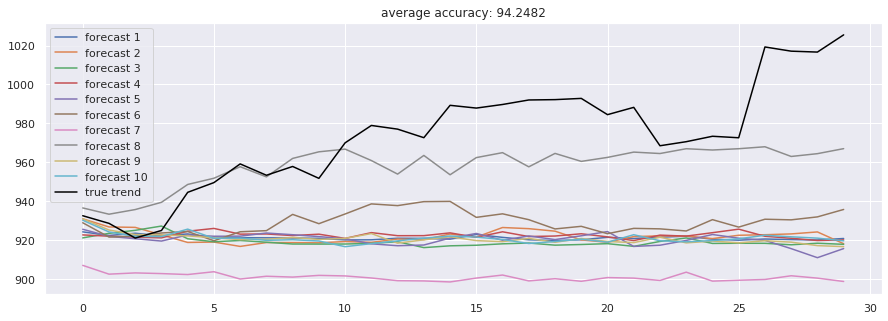

In [10]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()